In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import class_weight
from collections import Counter
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, GRU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [4]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/pawel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/pawel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Załadowanie plików z danymi

Pliki z danymi znajduję się w folderze `./data/`:

In [6]:
!ls ./data

test.tsv  train.tsv  valid.tsv


In [7]:
train_data = pd.read_csv('./data/train.tsv', sep='\t')

In [8]:
train_data.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


W danych walidacyjnych i testowych brakuje nagłówków, więc dodaję je z pliku treningowego.

In [9]:
valid_data = pd.read_csv('./data/valid.tsv', sep='\t', header=None, names=train_data.columns)

In [10]:
valid_data.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,140461,7622,democracy,2
1,140462,7622,and civic action laudable,3
2,140463,7622,civic action laudable,2
3,140464,7622,action laudable,3
4,140465,7623,Griffin & Co. manage to be spectacularly outra...,4


In [11]:
valid_data.tail()

,PhraseId,SentenceId,Phrase,Sentiment
7795,148256,8068,a storm,2
7796,148257,8068,as a fringe feminist conspiracy theorist,1
7797,148258,8068,a fringe feminist conspiracy theorist,2
7798,148259,8068,fringe feminist conspiracy theorist,1
7799,148260,8068,fringe,2


In [12]:
test_data = pd.read_csv('./data/test.tsv', sep='\t', header=None, names=train_data.columns)

In [13]:
test_data.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,148261,8068,feminist conspiracy theorist,2
1,148262,8068,conspiracy theorist,2
2,148263,8068,theorist,2
3,148264,8068,named Dirty Dick,2
4,148265,8068,Dirty Dick,2


In [14]:
test_data.tail()

,PhraseId,SentenceId,Phrase,Sentiment
7795,156056,8544,Hearst 's,2
7796,156057,8544,forced avuncular chortles,1
7797,156058,8544,avuncular chortles,3
7798,156059,8544,avuncular,2
7799,156060,8544,chortles,2


Sprawdzam czy istnieją komórki z wartością `NaN`:

In [15]:
list(map(lambda x: x.isnull().any().any(), (train_data, valid_data, test_data)))

[False, False, False]

# Wstępna analiza danych

## Forma i wygląd danych

Zdania oznaczone przez `SentenceId` są podzielone na frazy (`Phrase`), z których każda posiada określony `Sentiment`:

In [16]:
train_data.loc[train_data['SentenceId'] == 42]

,PhraseId,SentenceId,Phrase,Sentiment
1134,1135,42,Vincent Gallo is right at home in this French ...,3
1135,1136,42,Vincent Gallo,2
1136,1137,42,Vincent,2
1137,1138,42,Gallo,2
1138,1139,42,is right at home in this French shocker playin...,3
1139,1140,42,is right at home in this French shocker playin...,3
1140,1141,42,is right at home in this French shocker,2
1141,1142,42,right at home in this French shocker,3
1142,1143,42,right at home,3
1143,1144,42,right,3


Powyższa ramka danych uświadamia, że w skład `Phrase` wchodzą zarówno jednowyrazowe napisy oraz napisy składające się z wielu wyrazów. Warto zauważyć, że niektóre `Phrase` składają się tylko z tzw. *stopwords*. Okazuje się, że frazy będące stopwords to nieznaczna część danych, więc w dalszych krokach będę używał metody wykluczania stopwords:

In [17]:
train_data['Phrase'].apply(lambda x: x in stopwords.words('english')).value_counts(normalize=True)

False    0.999179
True     0.000821
Name: Phrase, dtype: float64

Czy we frazach występują znaki interpunkcyjne:

In [18]:
train_data['Phrase'].apply(lambda x: any([punc in x for punc in string.punctuation])).value_counts(normalize=True)

False    0.573704
True     0.426296
Name: Phrase, dtype: float64

### Rozkład zmiennej zależnej według fraz

Sprawdzam jaki jest rozkład zmiennej zależnej (`Sentiment`) według fraz składających się na zdania (`PhraseId`). Przeważa klasa środkowa, czyli neutralna. Rozkład podobny dla wszystkich trzech zestawów danych. Interesujące jest to, że frazy oznaczone jako skrajne(`0` oraz `4`) są średnio najdłuższe:

In [19]:
def get_by_phrase_stats(set_df):
    no_rows = set_df.shape[0]

    aggregation = {
        'Phrase': {
            'count': 'count',
            'freq': lambda x: x.shape[0]/no_rows,
            'avg_number_of_words': lambda x: np.mean([len(phrase.split()) for phrase in x])
        }    
    }

    return set_df.groupby('Sentiment').agg(aggregation)

In [20]:
list(map(lambda x: get_by_phrase_stats(x), (train_data, valid_data, test_data)))

/home/pawel/.local/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4656: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


[          Phrase                              
            count      freq avg_number_of_words
 Sentiment                                     
 0           6318  0.045129           12.035296
 1          24081  0.172008            9.076118
 2          71738  0.512418            5.139466
 3          29602  0.211444            8.404229
 4           8260  0.059000           10.662228,
           Phrase                              
            count      freq avg_number_of_words
 Sentiment                                     
 0            328  0.042051           13.435976
 1           1519  0.194744            9.903226
 2           3788  0.485641            5.714361
 3           1696  0.217436            8.825472
 4            469  0.060128           11.285714,
           Phrase                              
            count      freq avg_number_of_words
 Sentiment                                     
 0            417  0.053462           12.177458
 1           1605  0.205769           

# Zdefiniowane zadania

W dalszych krokach będę próbował określić wartość kolumny `Sentiment` dla każdej z `Phrase`.

# Podejście z pełnymi zdaniami - ustalenie benchmarku

W tym podejściu skupiam się jedynie na pełnych zdaniach. Innymi słowy ignoruję podział zdania na frazy i jedynie na podstawie całego zdania próbuję określić wartość `Sentiment`. Dla fraz wchodzących w skład danego zdania przypiszę wartości `Sentiment` uzyskane dla tego zdania. Ze względu na niedoskonałość tego podejścia będę mógł je potraktować jako swego rodzaju benchmark.

W zestawie treningowym i walidacyjnym zostawiam tylko pełne zdania:

In [21]:
train_data_full_sent_only = train_data.drop_duplicates(subset='SentenceId')

In [22]:
train_data_full_sent_only.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
63,64,2,"This quiet , introspective and entertaining in...",4
81,82,3,"Even fans of Ismail Merchant 's work , I suspe...",1
116,117,4,A positively thrilling combination of ethnogra...,3
156,157,5,Aggressive self-glorification and a manipulati...,1


In [23]:
valid_data_full_sent_only = valid_data.drop_duplicates(subset='SentenceId')

In [24]:
valid_data_full_sent_only.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,140461,7622,democracy,2
4,140465,7623,Griffin & Co. manage to be spectacularly outra...,4
14,140475,7624,Like The English Patient and The Unbearable Li...,3
49,140510,7625,`` Auto Focus '' works as an unusual biopic an...,3
68,140529,7626,"Very amusing , not the usual route in a thrill...",3


Poniższa funkcja sprowadza dane zdanie do mniej złożonej reprezentacji (nadal literowej):

In [25]:
stemmer = WordNetLemmatizer()

def simplify_sentence(sentence):
    # usuwanie znaków specjalnych (wszystkich poza alfanumerycznymi)
    sentence = re.sub(r'\W', ' ', sentence)
    
    # usuwanie wszystkich pojedynczych liter
    sentence = re.sub('(\\b[A-Za-z] \\b|\\b [A-Za-z]\\b)', '', sentence)

    # zamiana na małe litery
    sentence = sentence.lower()
    
    # wyciągnięcie pojedynczych słów
    sentence = sentence.split()
    
    # sprowadzenie słów do form podstawowych (lematów)
    # uwaga: sentence to teraz lista
    sentence = [stemmer.lemmatize(word) for word in sentence]
    
    # powrót do str
    return " ".join(sentence)

In [26]:
train_data_full_sent_only['Phrase_cleaned'] = train_data_full_sent_only['Phrase'].apply(lambda x: simplify_sentence(x))

/home/pawel/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [27]:
valid_data_full_sent_only['Phrase_cleaned'] = valid_data_full_sent_only['Phrase'].apply(lambda x: simplify_sentence(x))

/home/pawel/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Zamieniam uproszczone (wyczyszczone zdania) na reprezentację bag of words. 

`max_features`: zwracam uwagę na 1000 najczęściej występujących słów, 

`min_df` to minimalna liczba zdań, w których musi wystąpić słowo, żeby nie zostać zignorowanym, 

`max_df` to maksymalny odsetek wszystkich zdań, w których słowo może wystąpić - służy do zignorowania słów, które występują w prawie każdym zdaniu

`stop_words` to słowa, które występują na tyle często w języku, że nie wnoszą żadnych informacji w zadaniu klasyfikacji

In [28]:
vectorizer = CountVectorizer(max_features=30, min_df=5, max_df=0.75, stop_words=stopwords.words('english'))  

In [29]:
train_data_vectorized = vectorizer.fit_transform(train_data_full_sent_only['Phrase_cleaned'])

In [30]:
valid_data_vectorized = vectorizer.fit_transform(valid_data_full_sent_only['Phrase_cleaned'])

Dotychczasowa reprezentacja wektorowa zdań mimo że uwzględnia fakt bardzo rzadkich słów (`min_df`) oraz słów występujących w prawie każdym zdaniu (`max_df`) może zostać ulepszona podejściem TFIDF. Podejście to nadaje większą wagę słowom bardziej informatywnym, tzn. tym które występują często w małej ilości zdań.

In [31]:
tfidfconverter = TfidfTransformer()  
train_data_tfidf = tfidfconverter.fit_transform(train_data_vectorized).toarray() 

In [32]:
valid_data_tfidf = tfidfconverter.fit_transform(valid_data_vectorized).toarray() 

Używam lasu losowego z 500 drzewami w celu dokonania klasyfikacji:

In [33]:
rf_classifier = RandomForestClassifier(n_estimators=500, random_state=0) 

In [34]:
rf_classifier.fit(train_data_tfidf, train_data_full_sent_only['Sentiment'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

Przygotowuję dane testowe, na podstawie których dokonam predykcji:

In [35]:
test_data_full_sent_only = test_data.drop_duplicates(subset='SentenceId')

In [36]:
test_data_full_sent_only['Phrase_cleaned'] = test_data_full_sent_only['Phrase'].apply(lambda x: simplify_sentence(x))

/home/pawel/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [37]:
test_data_vectorize = vectorizer.fit_transform(test_data_full_sent_only['Phrase_cleaned'])

In [38]:
test_data_tfidf = tfidfconverter.fit_transform(test_data_vectorize).toarray()

In [39]:
y_pred = rf_classifier.predict(test_data_tfidf)

`y_pred` muszą zostać skopiowane do odpowiadających `PhraseId`, aby można było obliczyć dokładność klasyfikatora. Z jednej strony mam tyle unikalnych `SentenceId` w `test_data`:

In [40]:
len(y_pred)

475

... z drugiej strony w `test_data` jest tyle unikalnych `PhraseId`:

In [41]:
test_data.shape[0]

7800

Wykonuję złączenie dwóch ramek danych po `SentenceId`:

In [42]:
sent_only_preds = pd.DataFrame(data={"predicted_class": y_pred, "SentenceId": test_data_full_sent_only['SentenceId']}, index=test_data_full_sent_only.index)

In [43]:
sent_only_preds.head()

,predicted_class,SentenceId
0,3,8068
5,1,8069
23,3,8070
61,4,8071
71,1,8072


In [44]:
test_data_w_predicted = pd.merge(test_data, sent_only_preds, how='left', on='SentenceId')
test_data_w_predicted.head()

,PhraseId,SentenceId,Phrase,Sentiment,predicted_class
0,148261,8068,feminist conspiracy theorist,2,3
1,148262,8068,conspiracy theorist,2,3
2,148263,8068,theorist,2,3
3,148264,8068,named Dirty Dick,2,3
4,148265,8068,Dirty Dick,2,3


Biorąc pod uwagę tragiczne wyniki klasyfikatora za benchmark w dalszych rozważaniach będę uznawał częstość występowania klasy dominującej w zdaniach:

In [45]:
print(accuracy_score(test_data_w_predicted['Sentiment'], test_data_w_predicted['predicted_class']))
print("Benchmark dla accuracy będzie wynosił: ", max(get_by_phrase_stats(test_data)['Phrase']['freq']))

0.20717948717948717
Benchmark dla accuracy będzie wynosił:  0.49


/home/pawel/.local/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4656: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


# Modelowanie embeddingsów

## Czyszczenie danych

Poniżej zdefiniowana funkcja jest zbyt agresywna, ponieważ dla niektórych obserwacji w `Phrase` (np. tych zawierających same *stopwords*) będzie zwracała puste napisy. W jej miejsce stosuję wyrażenie regularne, które usuwa wszystkie znaki poza literami łacińskimi (małymi i wielkimi), cyframi oraz odstępami (np. spacje, taby, nowe linie). Mimo, że wykorzystany w dalszej części obiekt `Tokenizer` filtruje po znakach m.in. znakach odstępu (`\s`) usuwając je, to na razie muszę zostawić odstępy, które stanowią granicę wyrazów (tokenów) w zdaniu.

In [45]:
def clean_doc(doc):
    # split into tokens by white space
    tokens = doc.split()
    # remove punctuation from each token
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    return " ".join(tokens)

In [46]:
train_data['Phrase'] = train_data['Phrase'].apply(lambda x: re.sub('[^a-zA-z0-9\s]', '', x))

In [47]:
train_data.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [49]:
test_data['Phrase'] = test_data['Phrase'].apply(lambda x: re.sub('[^a-zA-z0-9\s]', '', x))

In [50]:
test_data.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,148261,8068,feminist conspiracy theorist,2
1,148262,8068,conspiracy theorist,2
2,148263,8068,theorist,2
3,148264,8068,named Dirty Dick,2
4,148265,8068,Dirty Dick,2


Na wejściu do sieci musi pojawiać się wektor stałej długości. Dodatkowym wymaganiem jest to, żeby słowa w nim zawarte były zakodowane jako liczby.

In [51]:
X_tr = train_data['Phrase']
y_tr = train_data['Sentiment']

Definiuję `Tokenizer`, którego jednym z argumentów jest m.in. to ile słów z wejścia zachowa. Domyślne ustawienia (`num_words`) to `num_words-1`, co oznacza, że słowa o najniższej częstości występowania nie przejdą etapu tokenizacji. Wydaje się to rozsądnym pomysłem, ponieważ słowa najrzadziej występujące to zazwyczaj te występujące tylko raz. Dodatkowo przerabiam wszystkie znaki na wersje pisane małą literą (argument `lower=True`).

In [52]:
tokenizer = Tokenizer()

W tym kroku tworzę słownik, który ma następującą postać `słownik['the']=1`, czyli każde słowo z zestawu treningowego jest kodowane jako liczba.

In [53]:
tokenizer.fit_on_texts(X_tr.values)

In [55]:
X_ts = test_data['Phrase']

Poniżej elementy zdania zamieniane są na liczby:

In [56]:
X_tr_tokenized = tokenizer.texts_to_sequences(X_tr)
X_ts_tokenized = tokenizer.texts_to_sequences(X_ts)

Poniższy przykład pokazuje, że zdania zostały zamienione na listy długości równej liczbie tokenów w pierwotnych (ale oczyszczonych regexem) zdaniach:

In [57]:
X_tr[55], X_tr_tokenized[55]

('to much of a story', [5, 54, 3, 2, 40])

In [58]:
X_ts[22], X_ts_tokenized[22]

('for excitement', [13, 1472])

Należy wyrównać listy do tej samej długości (długości najliczniejszego pod względem tokenów zdania). Argument `padding='post'` wskazuje, że w krótszych niż `max_len` zdaniach zera będą dodane na końcu:

In [59]:
max_len = max([len(x.split()) for x in train_data['Phrase']])
max_len

48

In [60]:
X_tr_tokenized = pad_sequences(X_tr_tokenized, max_len, padding='post')

In [61]:
X_tr_tokenized

array([[   2,  316,    3, ...,    0,    0,    0],
       [   2,  316,    3, ...,    0,    0,    0],
       [   2,  316,    0, ...,    0,    0,    0],
       ...,
       [ 280,  442, 3148, ...,    0,    0,    0],
       [   8,   28,  482, ...,    0,    0,    0],
       [  28,  482,   17, ...,    0,    0,    0]], dtype=int32)

In [62]:
X_ts_tokenized = pad_sequences(X_ts_tokenized, max_len, padding='post')

Długość tokenizowanych zdań w obu zestawach jest równa:

In [64]:
X_tr_tokenized.shape[1] == X_ts_tokenized.shape[1]

True

### Budowa sieci - Model 1

Każdy z wektorów zanurzonych w sieci będzie miał wymiar 300. Zgodnie z dokumentacją `input_dim` w `Embedding()` musi być równy liczbie słów plus 1 (plus 1, aby ująć `0` za pomocą, którego wypełnia się wektory krótsze niż maksymalny wymiar). `input_length` to argument informujący o długości wejścia.

In [63]:
embeddings_dim = 300
no_epochs = 50
input_dim = len(tokenizer.word_index)+1
model = Sequential()
model.add(Embedding(input_dim=input_dim, output_dim=embeddings_dim, input_length=max_len))

Warstwa Long Short Term Memory (`LSTM`) oraz warstawa klasyfikująca `Dense`, w której umieszczam 5 neuronów (jedna dla każdej z przewidywanych klas).

In [64]:
model.add(LSTM(units=128, dropout=0.33, recurrent_dropout=0.33))
model.add(Dense(units=5, activation='softmax'))

W0528 07:05:01.532825 140336562521920 deprecation.py:506] From /home/pawel/anaconda3/lib/python3.6/site-packages/tensorflow/python/keras/backend.py:4081: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Warto zwrócić uwagę na funkcję straty `'sparse_categorical_crossentropy'`, która powinna być używana w przypadku, gdy klasy są rozłączne. W naszym przypadku oznacza to, że ostatnia warstwa nie zwraca prawdopodobieństw należenia do różnych klas. Wspomniana funkcja jest używana, gdy zmienna zależna nie jest kodowana w postaci one-hot, lecz jako liczby całkowite (np. 1, 2, 3, 4, 5).

In [65]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['mse', 'acc'])

In [66]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 48, 300)           4621800   
_________________________________________________________________
unified_lstm (UnifiedLSTM)   (None, 128)               219648    
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
Total params: 4,842,093
Trainable params: 4,842,093
Non-trainable params: 0
_________________________________________________________________


W tym miejscu należy zdefiniować dane walidacyjne, które należy przekazać w argumencie `validation_data`. 

In [65]:
X_val = valid_data['Phrase']
y_val = valid_data['Sentiment']

X_val_tokenized = tokenizer.texts_to_sequences(X_val)
X_val_tokenized = pad_sequences(X_val_tokenized, max_len, padding='post')

In [66]:
X_val_tokenized.shape

(7800, 48)

Aby zaradzić wcześniej wspomnianemu problemowi niezbalansowanych danych treningowych będę odpowiednio ważył obserwacje z każdej kategorii. Kategoria najliczniejsza (`2`) ma teraz najmniejszą wagę:

In [67]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_tr),
                                                 y_tr)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 4.431750553972776,
 1: 1.1627341057265064,
 2: 0.3903063927067942,
 3: 0.9458752786973853,
 4: 3.3898062953995156}

Wstępne testy pokazały, że źle zdefininiowałem mechanizm early stopping, który automatycznie zatrzyma trening jeżeli wcześniej określone kryterium nie zostanie spełnione. Proces treningu zostanie zatrzymany, jeżeli model w 5 epokach nie wykaże się wzrostem `accuracy` na zestawie walidacyjnym na poziomie co najmniej 0.003. Korzystam z `min_delta`, aby wykluczyć początkowe etapy treningu, gdzie mogą występować znaczące fluktuacje pomiędzy epokami. Innymi słowy ustalone zasady zaczynają obowiązywać dopiero po przekroczeniu `val_acc` równego 0.5. W dalszej części nie korzystam z tego mechanizmu.

In [70]:
early_stopping = EarlyStopping(min_delta=0.001, 
                               monitor='val_acc', 
                               patience=5, 
                               mode='max',
                               verbose=1,
                               baseline=0.5)

Stosuję także podejście pozwalające zapisać wersję modelu z treningu, którą cechowała najlepsza wskazana cecha. Tutaj skupię się na funkcji straty dla zestawu walidacyjnego (która powinna być minimalizowana):

In [71]:
mc1 = ModelCheckpoint('./models/model_val_loss_1.h5', 
                     monitor='val_loss', 
                     mode='min', 
                     save_best_only=True,
                     verbose=1)

In [72]:
# callback = [mc]
# callback = [early_stopping, mc]

In [73]:
history = model.fit(x=X_tr_tokenized, 
          y=y_tr, 
          epochs=no_epochs, 
          verbose=1,
          batch_size=128,
          validation_data=(X_val_tokenized, y_val),
          class_weight=class_weights,
          callbacks=[mc1])

Train on 139999 samples, validate on 7800 samples
Epoch 1/50
139904/139999 [============================>.] - ETA: 0s - loss: 1.6040 - mse: 4.2827 - acc: 0.2074
Epoch 00001: val_loss improved from inf to 1.56522, saving model to ./models/model_val_loss_1.h5
139999/139999 [==============================] - 151s 1ms/sample - loss: 1.6040 - mse: 4.2826 - acc: 0.2076 - val_loss: 1.5652 - val_mse: 4.2755 - val_acc: 0.4140
Epoch 2/50
139904/139999 [============================>.] - ETA: 0s - loss: 1.5828 - mse: 4.2843 - acc: 0.3837
Epoch 00002: val_loss improved from 1.56522 to 1.56504, saving model to ./models/model_val_loss_1.h5
139999/139999 [==============================] - 149s 1ms/sample - loss: 1.5827 - mse: 4.2842 - acc: 0.3836 - val_loss: 1.5650 - val_mse: 4.2779 - val_acc: 0.2551
Epoch 3/50
139904/139999 [============================>.] - ETA: 0s - loss: 1.3948 - mse: 4.2934 - acc: 0.3126
Epoch 00003: val_loss improved from 1.56504 to 1.36426, saving model to ./models/model_val_lo

Do ostatecznego sprawdzenia jakości modelu będą potrzebna zmienna zależna z zestawu testowego:

In [70]:
y_test = test_data['Sentiment']

In [75]:
model.evaluate(x=X_ts_tokenized, y=y_test)

7800/7800 [==============================] - 3s 370us/sample - loss: 1.9461 - mse: 4.1606 - acc: 0.5154


[1.946089681723179, 4.1606164, 0.5153846]

*Accuracy* dla zestawu testowego to o 2 pp więcej niż benchmark oparty o częstość występowania klasy dominującej.

In [78]:
with open('./pickles/history1.p', 'wb') as file:
    pickle.dump(history.history, file, protocol=pickle.HIGHEST_PROTOCOL)

Przy trenowaniu modeli w Jupyter Notebook zdarzało się, że włączony notebook zostawiony na noc przestawał odpowiadać w trakcie treningu. W celu zapobiegania tego typu zdarzeniom przenoszę trenowanie modeli do oddzielnych Pythonowych skryptów. Należy wyeksportować obiekty na podstawie, których stworzyłem powyższy model:

In [71]:
dict_to_export = {'X_tr_tokenized': X_tr_tokenized,
                 'y_tr': y_tr,
                 'X_val_tokenized': X_val_tokenized,
                 'y_val': y_val,
                 'class_weights': class_weights,
                 'X_ts_tokenized': X_ts_tokenized,\
                 'y_test': y_test,
                 'tokenizer': tokenizer,
                 'max_len': max_len}

Słownik obiektów zapisuję do pickle:

In [73]:
with open('./pickle_do_skryptu/dict_to_export.p', 'wb') as file:
    pickle.dump(dict_to_export, file, protocol=pickle.HIGHEST_PROTOCOL)

Pozostałe modele trenowane są z plików w folderze `./script_models`:

In [24]:
! ls script_models/ -l | grep 'model'

-rw-r--r-- 1 pawel pawel     2505 maj 29 13:00 model2_doubleLSTM.py
-rw-r--r-- 1 pawel pawel     2224 maj 29 13:09 model3_singleGRU.py
-rw-r--r-- 1 pawel pawel     2858 maj 29 16:17 model4_pretrained_non_trainable.py
-rw-r--r-- 1 pawel pawel     2342 maj 31 09:26 model5_conv1d_simple.py
-rw-r--r-- 1 pawel pawel     2535 maj 31 09:26 model6_LSTM_conv1d.py
-rw-r--r-- 1 pawel pawel     2728 maj 29 17:23 model7_conv1d_pretained_non_trainable.py
-rw-r--r-- 1 pawel pawel     2853 maj 29 17:37 model8_conv1d_pretraind_trainable.py
-rw-r--r-- 1 pawel pawel     2488 maj 29 18:44 model9_LSTM_after_conv1d.py
drwxr-xr-x 2 pawel pawel     4096 maj 29 22:30 saved_models


Funkcja rysująca wykresy dla modeli:

In [3]:
def plots_from_history(pickled_history):
    with open('./script_models/histories/' + pickled_history, 'rb') as file:
        history = pickle.load(file)
        
        plt.rcParams.update({'font.size': 18})

        plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

        plt.subplot(311)
        plt.plot(history['loss'])
        plt.plot(history['val_loss'])
        plt.title('Loss function')
        plt.ylabel('Loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')

        plt.subplot(312)
        plt.plot(history['acc'])
        plt.plot(history['val_acc'])
        plt.title('Model\'s accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')

        plt.subplot(313)
        plt.plot(history['mse'])
        plt.plot(history['val_mse'])
        plt.title('Model\'s MSE')
        plt.ylabel('MSE')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')

        plt.subplots_adjust(top=0.90, bottom=0.1, left=0.10, right=0.95, hspace=0.35,
                            wspace=0.35)

        plt.show()

## Model 1

Ten model to jedyny wytrenowany w tym notebook'u. Został opisany powyżej.

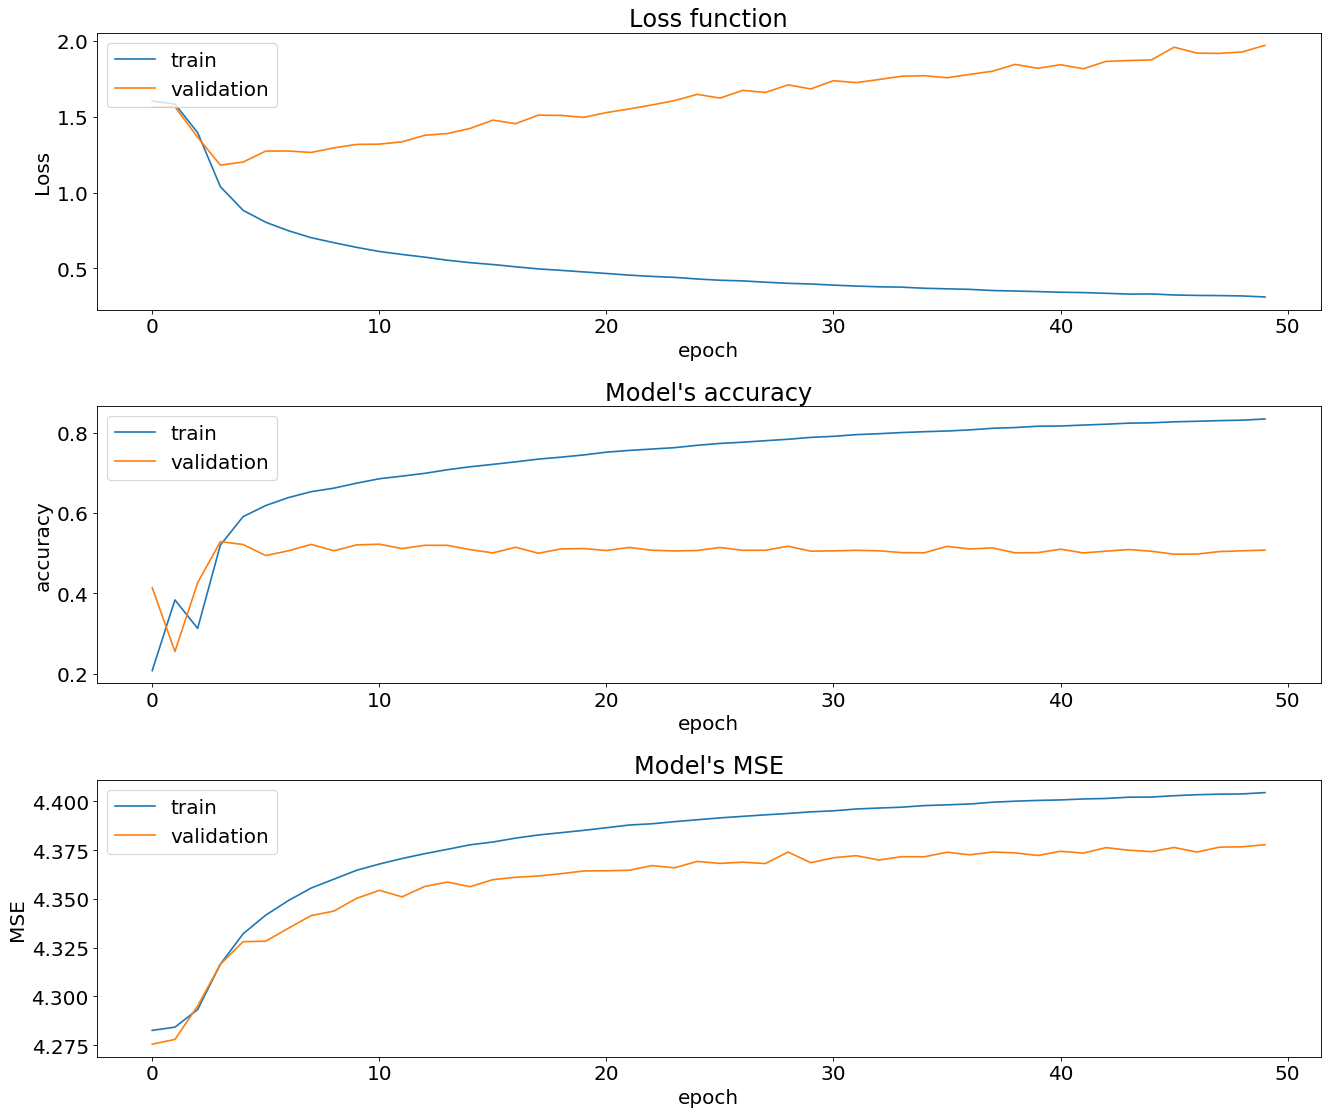

In [7]:
plots_from_history('history1.p')

Okazuje się, że liczba iteracji równa 50 to zbyt dużo, ponieważ po około 5 iteracjach model zaczął wykazywać oznaki przetrenowania: *accuracy* na stałym poziomie dla zestawu walidacyjnego, natomiast rosnąca w każdej iteracji dla zestawu walidacyjnego. Funkcja straty dla zestawu walidacyjnego, która zaczęła rosnąć w podobnym momencie wskazuje na to, że model raz odnalazł lokalne minimum i nigdy do niego nie wrócił.

## Model 2

Poniższa sieć stanowi udoskonalenie powyższej sieci. Do architektury dodałem drugą warstwę LSTM. Skorzystałem także z *dropout*, czyli techniki regularyzacyjnej, która tymczasowo usuwając neurony z sieci pozwala zmniejszyć stopień zbyt dużego dopasowania do danych treningowych (*overfitting*).

Plik z kodem: `./script_models/model2_doubleLSTM.py`.

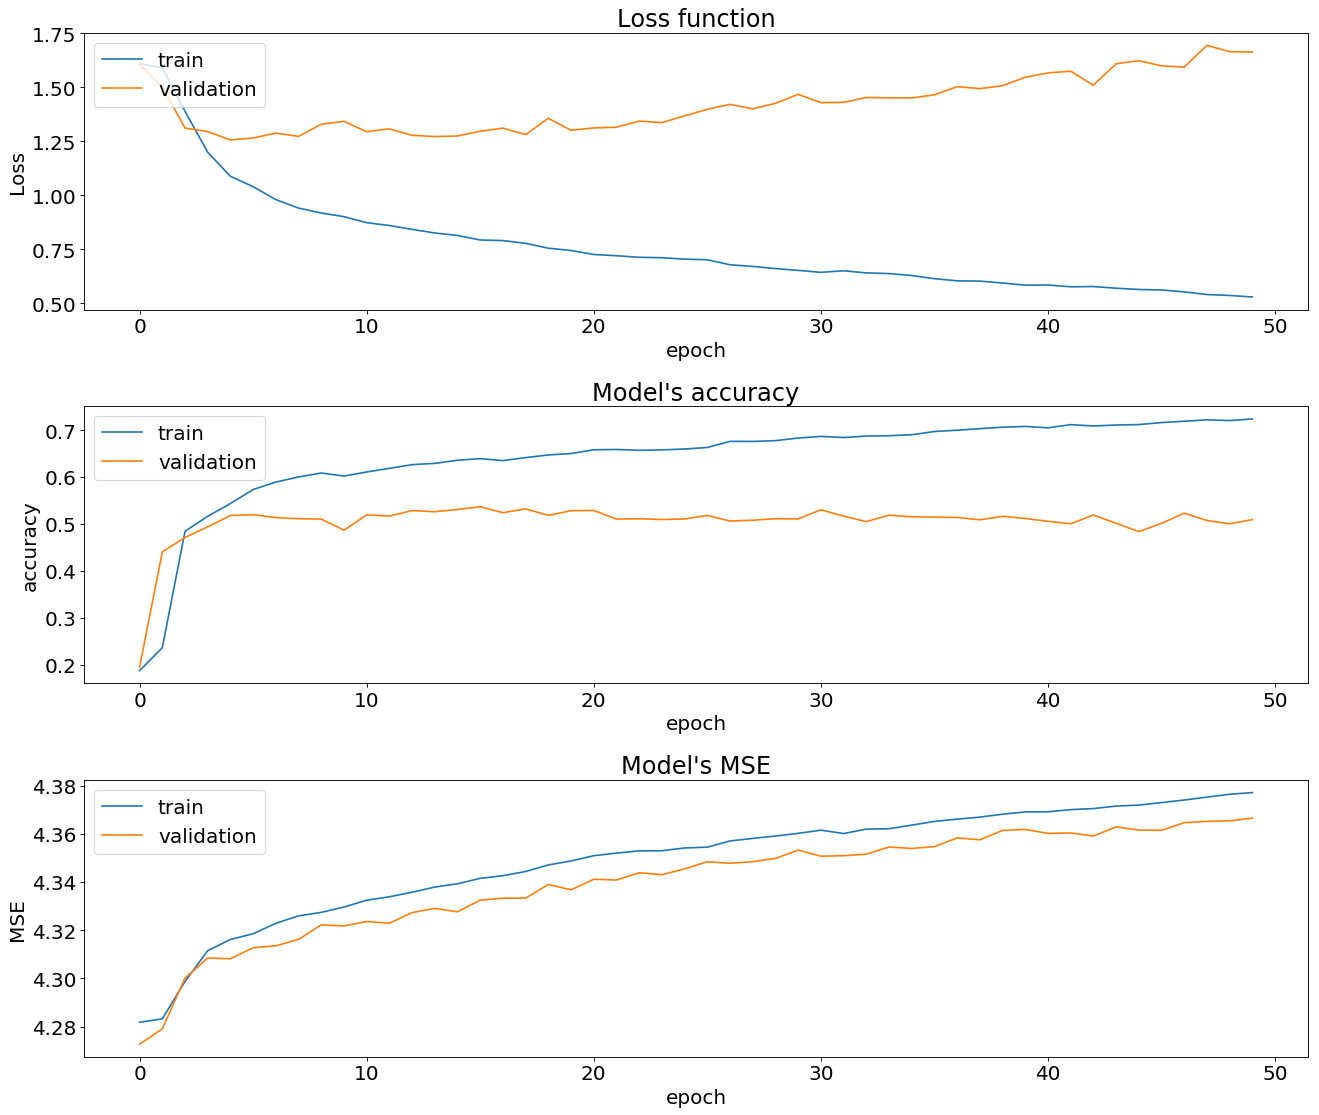

In [9]:
plots_from_history('model2_doubleLSTM_history.p')

*Accuracy* (drugi element listy) okazała się być niższa dla pierwszego modelu i tylko o 1 pp powyżej benchmarku.

In [42]:
! cat script_models/test_set_accuracy_outputs/model2_doubleLSTM.txt

[1.6489033917891673, 0.50961536, 4.1489973]


Wnioski co zbyt dużego dopasowania i kształtu wykresu funkcji straty takie same jak dla modelu nr 1.

## Model 3

Dodaję warstwę GRU, która różni się od LSTM liczbą bramek. Ta pierwsza posiada jedynie dwie (*reset* oraz *update*), natomiast ta druga posiada trzy (*input*, *output*, *forget*). Stosuję GRU, ponieważ ten wariant rekurencyjnej warstwy trenuje się szybciej. Ponadto w architekturze stawiam na większy dropout (0.8 w warsawie wejściowej) oraz więcej niż 0.5 w warstwach ukrytych. Takie podejście ma zapobiec przetrenowaniu.

Plik z kodem: `./script_models/model3_singleGRU.py`.

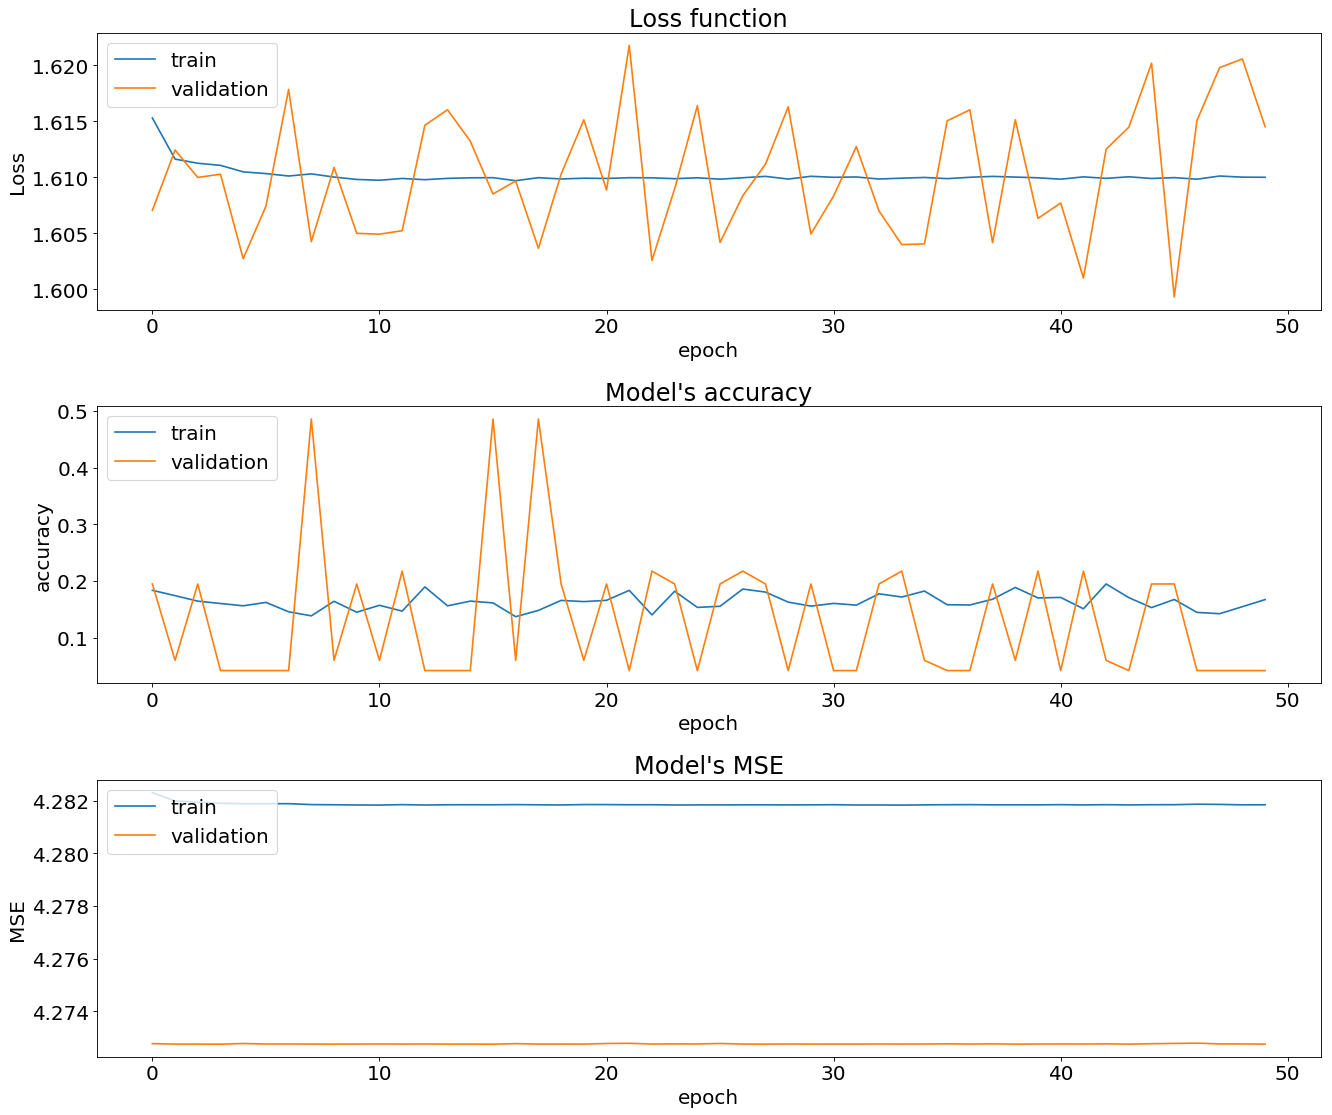

In [10]:
plots_from_history('model3_singleGRU_history.p')

Wykres dokładności (znaczące skoki z epoki na epokę) pokazuje, że zastosowałem zbyt duży współczynnik *dropout*. Można powiedzieć, że to czego model nauczył się w poprzedniej epoce były zapominane ze względu na tymczasowe wyłączenie z treningu neuronów, które miały wyuczoną jakąś cechę. Nie dziwi więc fakt, że *accuracy* dla danych testowych to 5%:

In [43]:
! cat script_models/test_set_accuracy_outputs/model3_singleGRU.txt

[1.6144472035383566, 0.053461537, 4.054695]


## Model 4

W poniższym podejściu wykorzystuję wytrenowane w podejściu [GloVe](https://nlp.stanford.edu/projects/glove/) embeddingi. W poniższej sieci nie pozwalam na dalsze trenowanie warstwy wektorów zanurzonych. Z jednej strony zaletą tego podejścia jest fakt, że wektory zostały uzyskane na o wiele większym korpusie niż ten dostępny w zadaniu, które rozwiązuję. Z drugiej strony słownictwo używane w korpusie powstałym na podstawie danych z rozwiązywanego zadania może nie być reprezentatywną próbką dużego korpusu, co utrudnia skorzystanie z założenia o *transfer learning*.

Wykorzystam 300 elementowe wektory zanurzone:

In [44]:
! ls ./glove/

glove.6B.100d.txt  glove.6B.300d.txt


In [32]:
embeddings_dim = 300

Ładuję wszystkie embeddingi do pamięci jako słownik przez co uzyskuję słownik, gdzie kluczem jest słowo, natomiast wartością wektor reprezentujący to słowo:

In [45]:
embeddings_glove = dict()
with open('./glove/glove.6B.300d.txt', 'r') as glove_file:
    for line in glove_file:
        vals = line.split()
        word = vals[0]
        coefs = np.asarray(vals[1:], dtype='float32')
        embeddings_glove[word] = coefs

In [46]:
len(embeddings_glove['the'])

300

In [47]:
embeddings_glove['the']

array([ 4.6560e-02,  2.1318e-01, -7.4364e-03, -4.5854e-01, -3.5639e-02,
        2.3643e-01, -2.8836e-01,  2.1521e-01, -1.3486e-01, -1.6413e+00,
       -2.6091e-01,  3.2434e-02,  5.6621e-02, -4.3296e-02, -2.1672e-02,
        2.2476e-01, -7.5129e-02, -6.7018e-02, -1.4247e-01,  3.8825e-02,
       -1.8951e-01,  2.9977e-01,  3.9305e-01,  1.7887e-01, -1.7343e-01,
       -2.1178e-01,  2.3617e-01, -6.3681e-02, -4.2318e-01, -1.1661e-01,
        9.3754e-02,  1.7296e-01, -3.3073e-01,  4.9112e-01, -6.8995e-01,
       -9.2462e-02,  2.4742e-01, -1.7991e-01,  9.7908e-02,  8.3118e-02,
        1.5299e-01, -2.7276e-01, -3.8934e-02,  5.4453e-01,  5.3737e-01,
        2.9105e-01, -7.3514e-03,  4.7880e-02, -4.0760e-01, -2.6759e-02,
        1.7919e-01,  1.0977e-02, -1.0963e-01, -2.6395e-01,  7.3990e-02,
        2.6236e-01, -1.5080e-01,  3.4623e-01,  2.5758e-01,  1.1971e-01,
       -3.7135e-02, -7.1593e-02,  4.3898e-01, -4.0764e-02,  1.6425e-02,
       -4.4640e-01,  1.7197e-01,  4.6246e-02,  5.8639e-02,  4.14

W zestawie treningowym w rozwiązywanym zadaniu pojawiają się tylko wybrane ze słów zawartych w `embeddings_glove`. Słowa, które się pojawiły zawarte są w `tokenizer`:

In [10]:
tokenizer = dict_to_export['tokenizer']

Inicjalizujące macierz embeddingową zerami. Warto zwrócić uwagę na to, że `vocabulary_size` to liczba słów w `tokenizer` plus 1, ponieważ trzeba obsłużyć 0, którymi wypełnione są zdania krótsze niż najdłuższe w zestawie treningowym zdanie. Jako, że używam embeddingsów 300-elementowych drugi wymiar musi być równy 300.

In [14]:
vocabulary_size = len(tokenizer.word_index) + 1

In [15]:
embedding_matrix = np.zeros((vocabulary_size, embeddings_dim))

Wypełniam macierz liczbowymi reprezentacjami słów znanych z zestawu treningowego:

In [21]:
for word, index in tokenizer.word_index.items():
    embedding = embeddings_glove.get(word)
    if embedding is not None:
        embedding_matrix[index] = embedding

Sprawdzam czy mapowanie przebiegło udanie dla przykładu `dog`:

In [26]:
tokenizer.word_index['dog']

614

In [30]:
all(embedding_matrix[614] == embeddings_glove['dog'])

True

Zapisuję `embedding_matrix` jako pickle:

In [54]:
with open('./pickle_do_skryptu/embedding_matrix.p', 'wb') as file:
    pickle.dump(embedding_matrix, file, protocol=pickle.HIGHEST_PROTOCOL)

Plik z kodem: `model4_pretrained_non_trainable.py`.

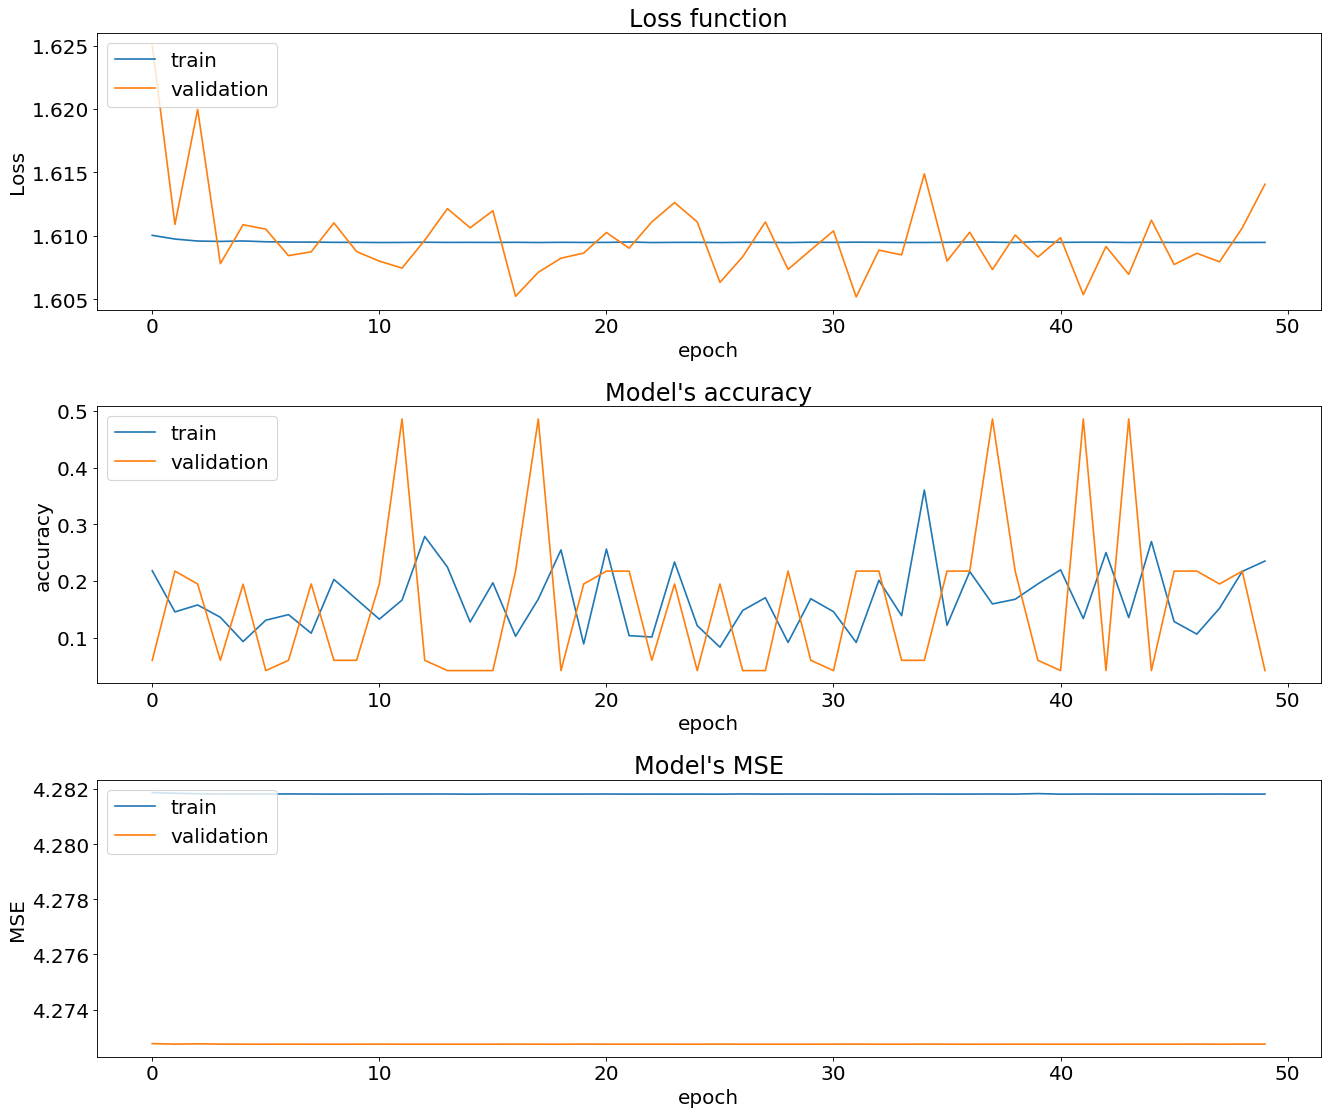

In [11]:
plots_from_history('model4_pretrained_non_trainable_history.p')

Wytrenowane wcześniej wektory zanurzone nie poradziły sobie z rozwiązywanym zadaniem. Świadczy o tym problem z generalizacją na zestaw walidacyjny (znaczne skoki *accuracy*) oraz niski poziom tej miary dla zestawu testowego:

In [48]:
! cat script_models/test_set_accuracy_outputs/model4_pretrained_non_trainable.txt

[1.6141771777470906, 0.053461537, 4.054695]


## Model 5

W poniższym podejściu stosuję warstwy konwolucyjne jednowymiarowe, które korzystają z okna zdefiniowanej szerokości (`kernel_size`) i przechodzą przez sekwencję agregując elementy z okna do jednej wartości. Do każdego tak powstałego okna aplikowane są wszystkie filtry (`filters`). Innymi słowy każdy z filtrów jest odpowiedzialny za rozpoznanie obecności jakiejś ukrytej cechy w każdym z okien.

W modelu pominąłem warstwę LSTM, żeby przyśpieszyć proces trenowania.

Plik z kodem: `model5_conv1d_simple.py`. 

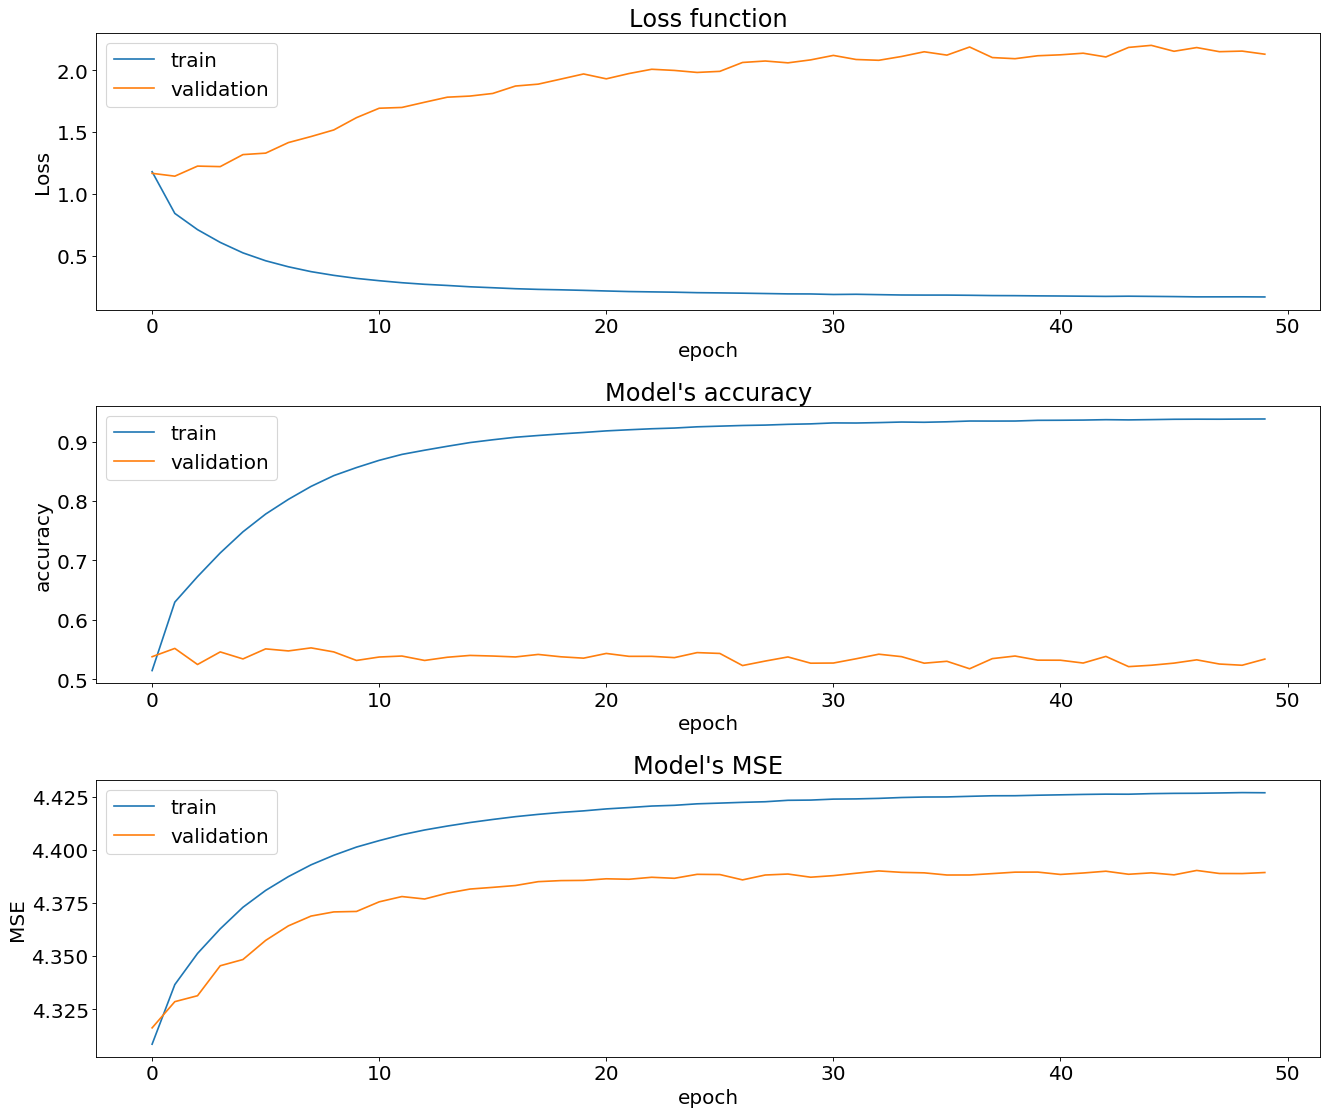

In [12]:
plots_from_history('model5_conv1d_simple_history.p')

Okazuje się, że warstwy konwolucyjne dobrze sprawdziły się w rozwiązywanym zdaniu. Świadczy o tym fakt, że model osiągnął *accuracy* na zestawie testowym o 4 pp. więcej niż dla benchmarku:

In [49]:
! cat script_models/test_set_accuracy_outputs/model5_conv1d_simple.txt

[2.1056129876161234, 0.5302564, 4.170827]


### Wersja 100 epok

Model został także wytrenowany w wariancie ze 100 epokami.

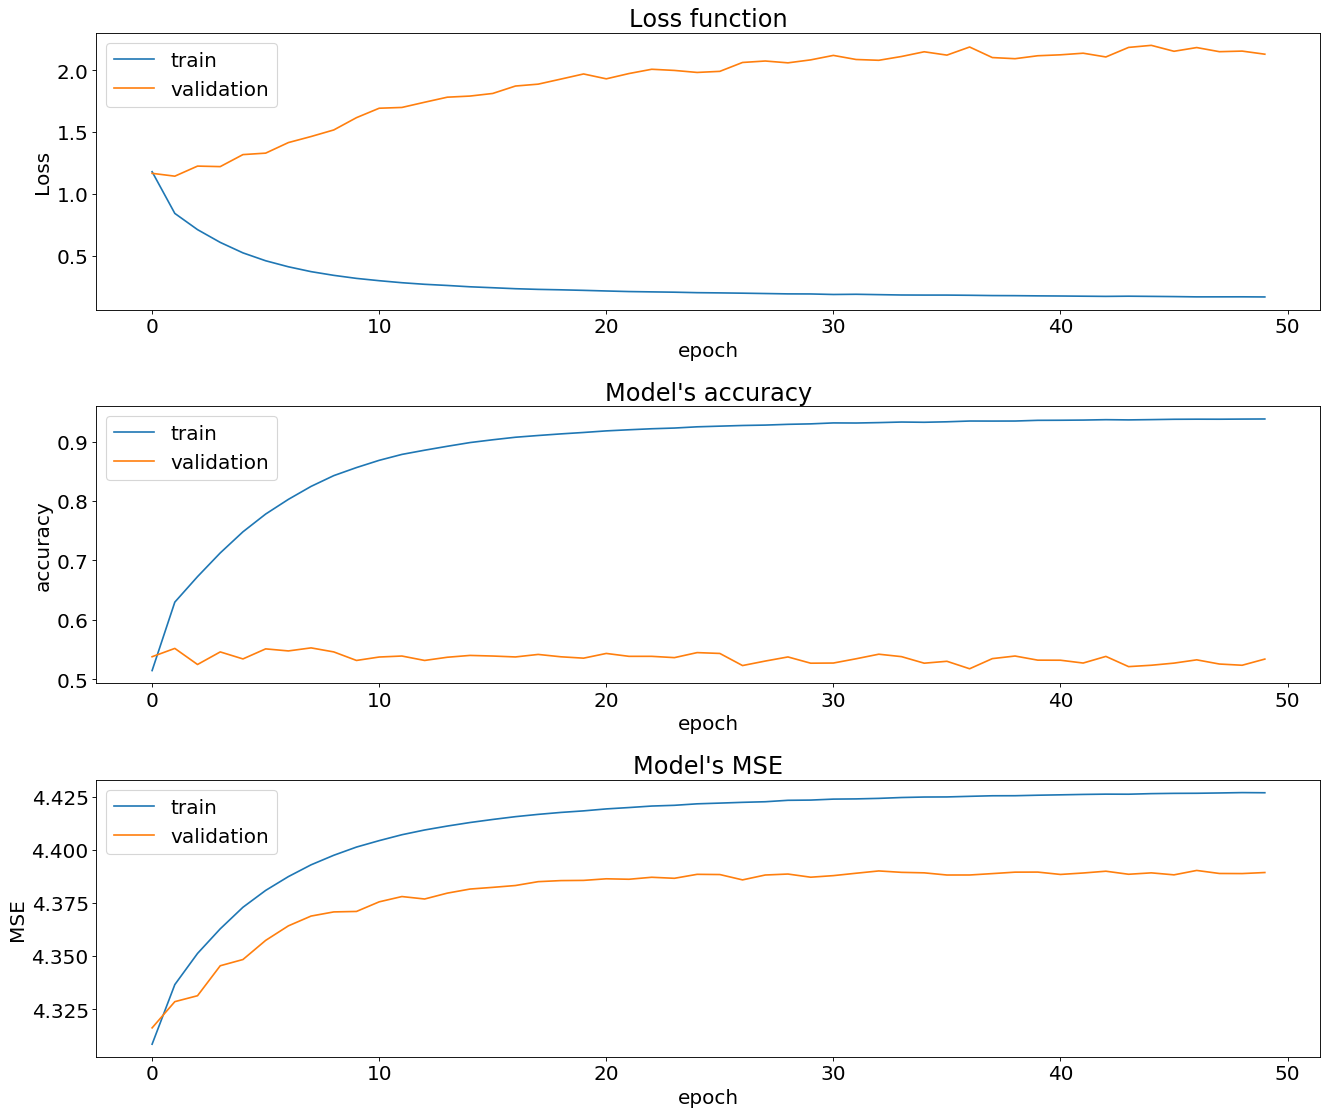

In [4]:
plots_from_history('model5_conv1d_simple_history.p')

Jako, że doszło do przetrenowania już w pierwszych 10 epokach fakt zwiększania liczby parametru określającego liczbę epok nie wpłynął na poprawę jakości modelu.

In [50]:
! cat script_models/test_set_accuracy_outputs/model5_conv1d_simple100_epochs.txt

[2.2110219347782625, 0.5170513, 4.165493]


## Model 6

Model ten stanowi rozbudowaną wersję poprzedniego modelu, ponieważ dodałem do niego dodatkową wartstwę konwolucyjną jednowymiarową oraz warstwę LSTM.

Plik z kodem: `model6_LSTM_conv1d.py`.

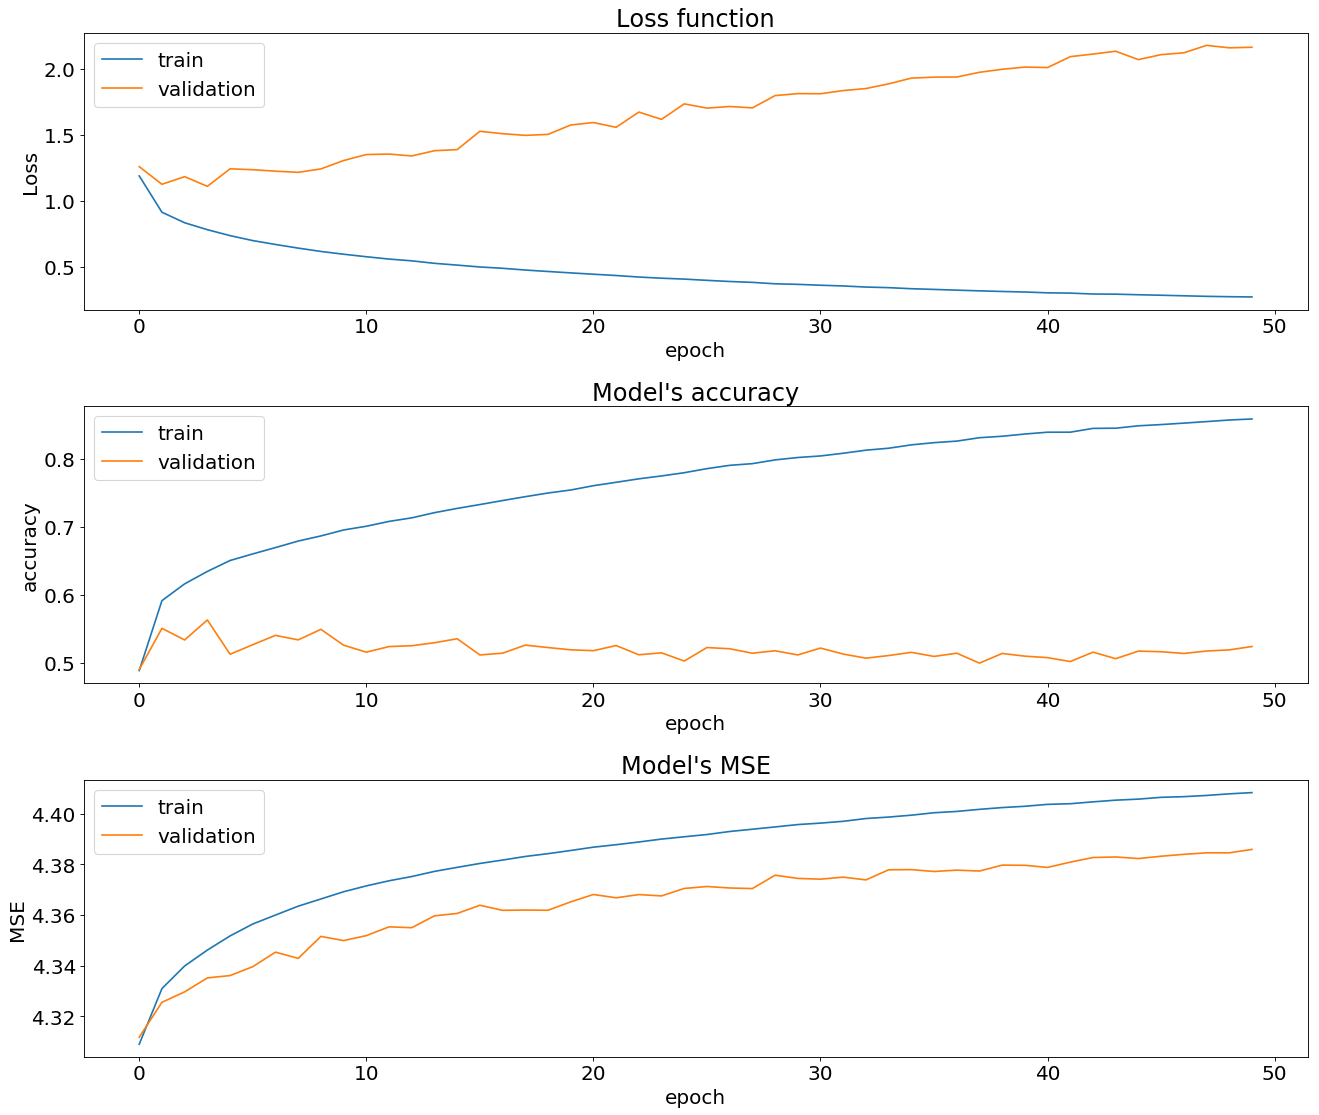

In [13]:
plots_from_history('model6_LSTM_conv1d_history.p')

Rozbudowanie modelu nr 5 do wersji z modelu nr 6 przyczyniło się do nieznacznej poprawy jakości modelu (*accuracy* na zestawie testowym). Być może w celu dalszego udoskonalania sieci należy postawić właśnie na warstwy konwolucyjne połączone z warstwami LSTM. W przypadku tego modelu także doszło do przetrenowania.

In [51]:
! cat script_models/test_set_accuracy_outputs/model6_LSTM_conv1d.txt

[2.1697891039726063, 0.5326923, 4.169361]


### Wersja 100 epok

Model został wytrenowany w wariance 100 epok.

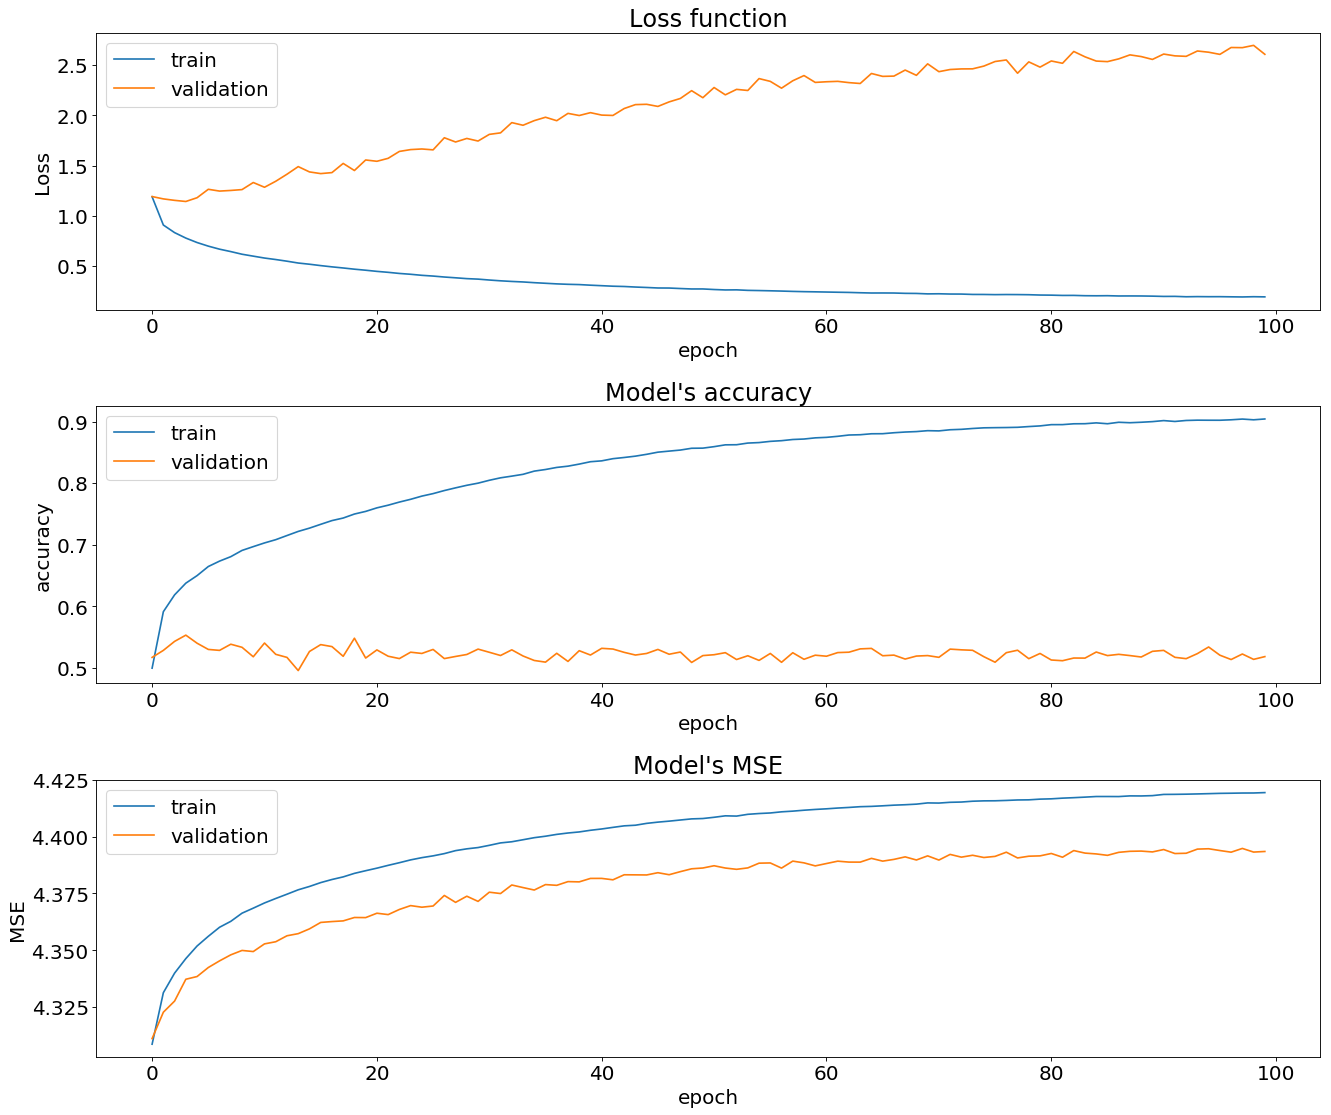

In [6]:
plots_from_history('model6_LSTM_conv1d100_epochs_history.p')

Większa liczba epok nie wpłynęła na poprawę jakości modelu ze względu na przetrenowanie na początku treningu (pierwsze 5 epok).

In [52]:
! cat script_models/test_set_accuracy_outputs/model6_LSTM_conv1d100_epochs.txt

[2.5207009907257865, 0.53205127, 4.1763186]


## Model 7

Model stanowi połączenie podejścia z wytrenowanymi wcześniej embeddingami oraz warstwami konwolucyjnymi.

Plik z kodem: `model7_conv1d_pretrained_non_trainable.py`.

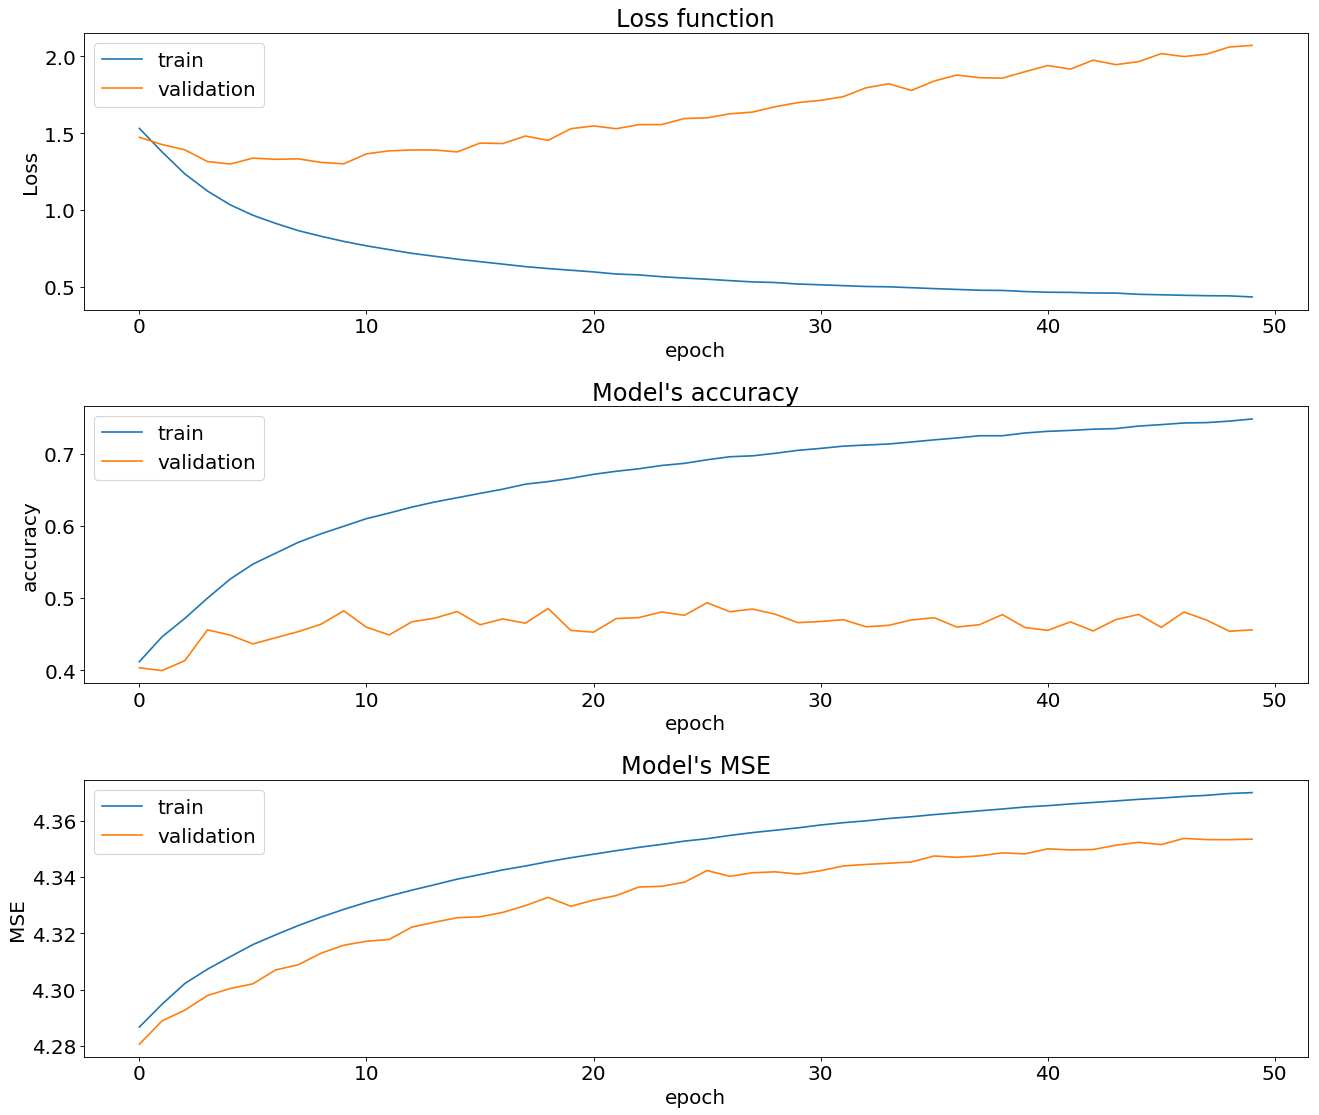

In [14]:
plots_from_history('model7_conv1d_pretained_non_trainable_history.p')

Model osiągnął niższą *accuracy* niż dla benchmarku. Warto zauważyć, że doszło do przetrenowania, ale dopiero po 10. epoce. Być może problemem jest fakt, że użyte zostały wcześniej wytrenowane embeddingi, które nie mogły zostać dopasowane do aktualnie rozwiązywanego problemu.

In [53]:
! cat script_models/test_set_accuracy_outputs/model7_conv1d_pretained_non_trainable.txt

[2.095096502120678, 0.47, 4.1342216]


## Model 8

W tym podejściu zezwalam na dotrenowywanie się wcześniej wytrenowanych embeddingów. Co prawda jest to domyślne podejście, gdy trenuję embeddingi od zera, natomiast w tej sytuacji różnica polega na inicjalizacji macierzy wektorów zanurzonych. Wektory zanurzone są inicjalizowane nie losowymi (lub takimi samymi liczbami), lecz wagami z GloVe.

Plik z kodem: `model8_conv1d_pretraind_trainable.py`.

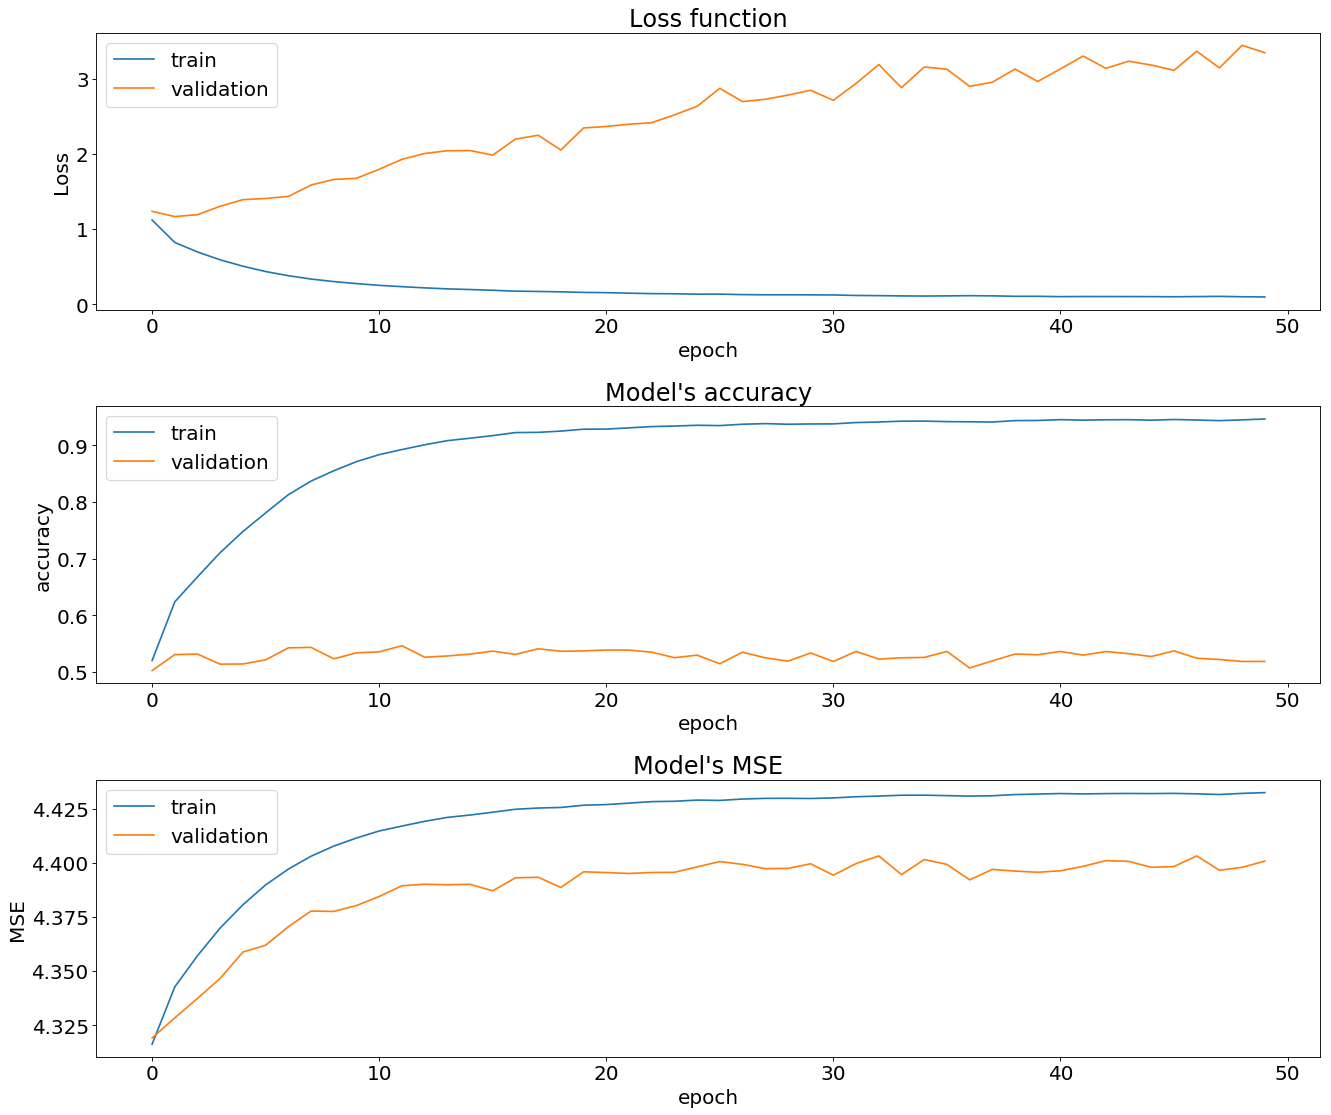

In [15]:
plots_from_history('model8_conv1d_pretraind_trainable_history.p')

Możliwość dotrenowaniu embeddingów GloVe pozwoliła uzyskać lepszy wynik dla zestawu testowego niż w przypadku embeddingów zamrożonych. Model osiągnął jednak *accuracy* większe o jedynie 2 pp. w porównaniu do benchmarku.

In [54]:
! cat script_models/test_set_accuracy_outputs/model9_LSTM_after_conv1d.txt

[3.0780076997708052, 0.5103846, 4.1908703]


## Model 9

Alternatywa dla modelu 6. Zamieniłem kolejność: najpierw umieszczam warstwy konwolucyjne, następnie warstwę LSTM.

Plik z kodem: `model9_LSTM_after_conv1d.py`.

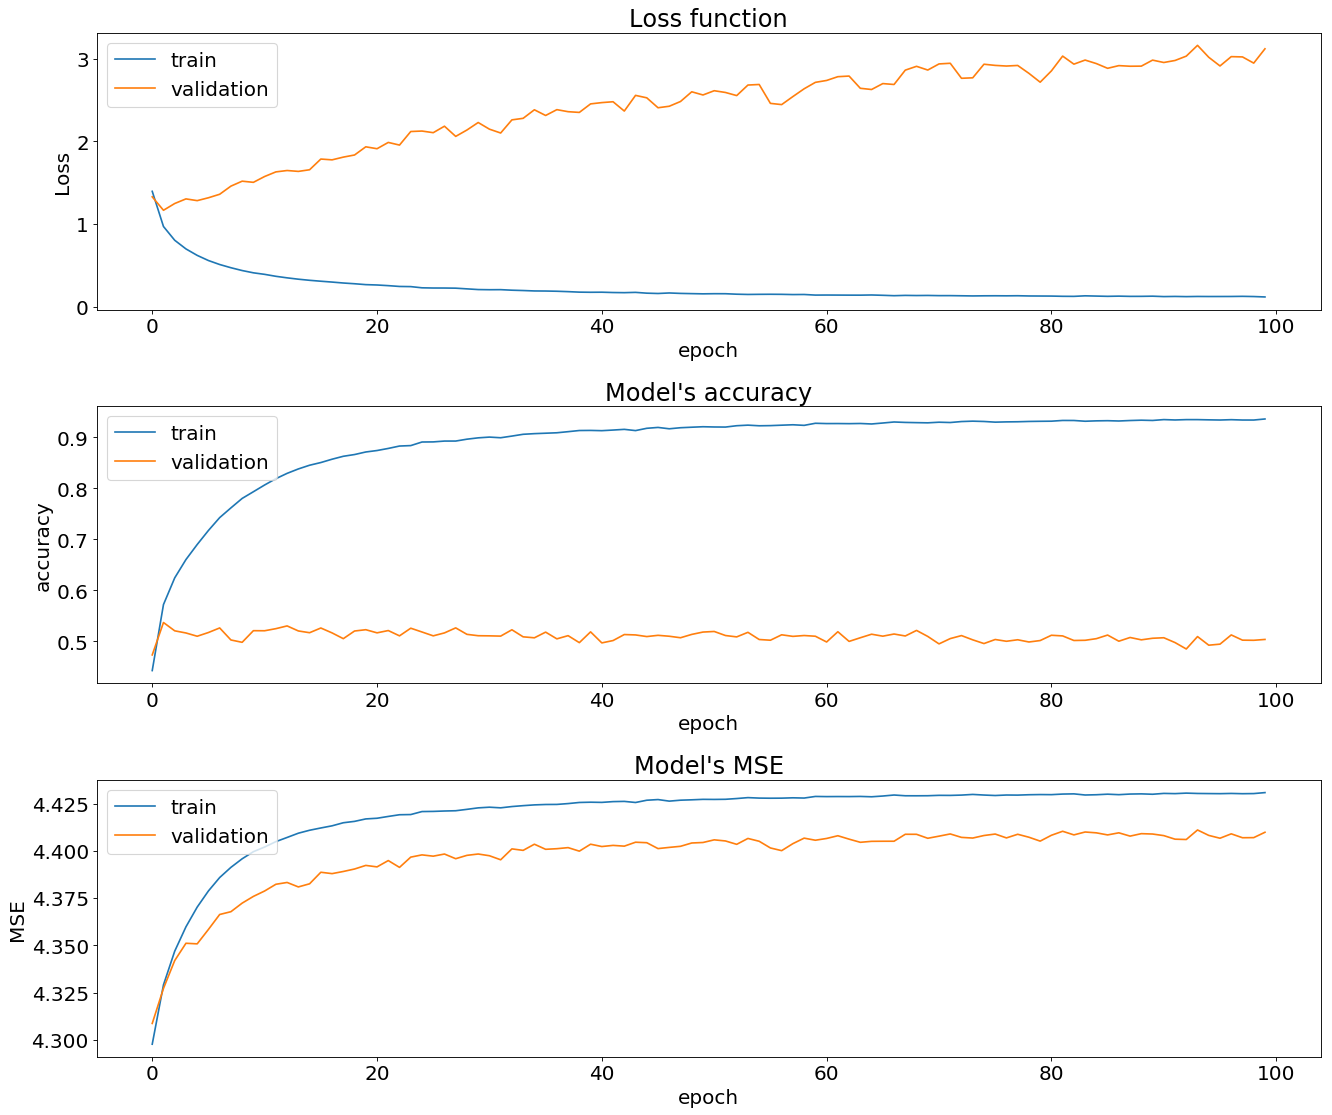

In [7]:
plots_from_history('model9_LSTM_after_conv1d_history.p')

Eksperyment polegający na zamianie kolejności: najpierw wyszukanie cech w zdaniach, a następnie przepuszczenie ich przez LSTM nie zdał eksperymentu. Wynik dla tego modelu jest niższy niż dla modelu nr 6, dla którego miał stanowić alternatywę.

In [55]:
! cat script_models/test_set_accuracy_outputs/model9_LSTM_after_conv1d.txt

[3.0780076997708052, 0.5103846, 4.1908703]


## Model 10

Poniższy model stanowi ulepszenie modelu nr 6, ponieważ zamiast zwykłej (jednokierunkowej) warstwy LSTM korzysta z biLSTM, czyli warstwy dwukierunkowej. Warstwa dwukierunkowa pozwala lepiej uchwycić kontekst, ponieważ korzysta jednocześnie z informacji z "przeszłości" oraz "przyszłości".

Plik z kodem: `model10_biLSTM_conv1d.py`.

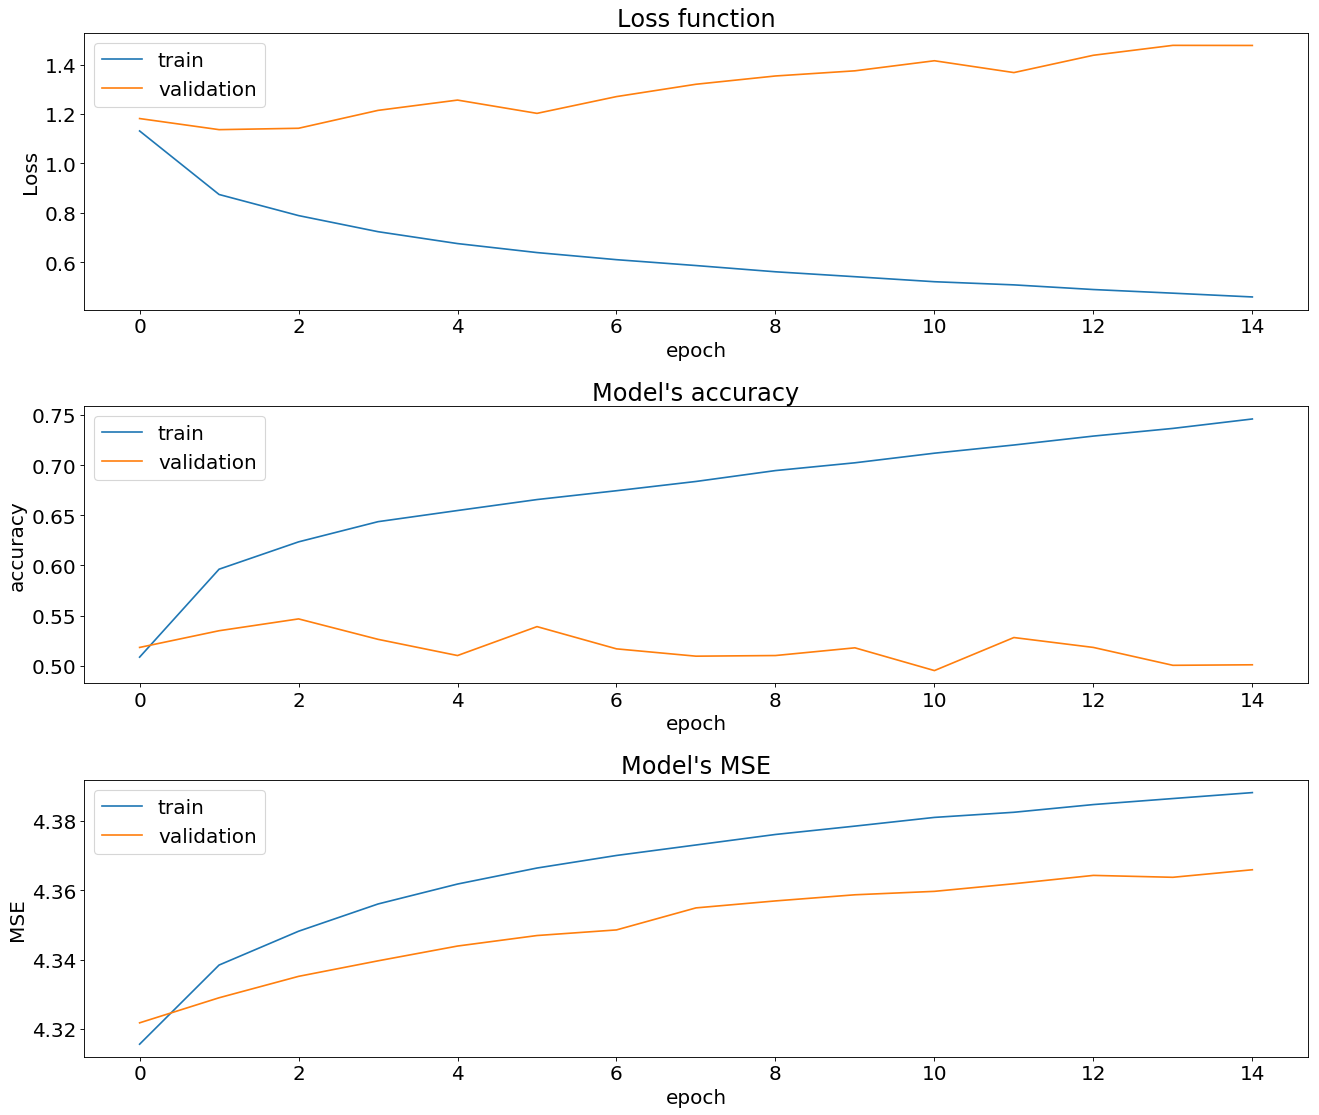

In [3]:
plots_from_history('model10_biLSTM_conv1d15_epochs_history.p')

Ulepszenia w architekturze sieci nie poprawiły wyników. *Accuracy* dla zestawu testowego jest nieznacznie większa niż benchmark:

In [4]:
! cat script_models/test_set_accuracy_outputs/model10_biLSTM_conv1d15_epochs.txt

[1.4980509969515678, 0.4969231, 4.1486545]


## Wnioski

Biorąc pod uwagę wszystkie z zaprezentowanych 10 modeli można skłaniać się ku wnioskom, że z zadaniem najlepiej poradziła sobie sieć oparta o jednowymiarowe warstwy konwolucyjne w połączeniu z warstwą LSTM. Warto zwrócić uwagę na zbyt duży *dropout*, który w niektórych przypadkach doprowadził do niezadowalających wyników. Wszystkie z testowanych sieci osiągnęły etap przetrenowania jeszcze przed osiągnięciem 10. epoki. Użycie wytrenowanych na dużych zbiorach danych embeddingów nie pomogło w poprawieniu jakości modelu mierzonej *accuracy*. Wręcz przeciwnie, aby wrócić do stanu wyjściowego (*accuracy* dla najlepszego modelu) konieczne było dotrenowanie tych embeddingów na danych treningowych.

## Postscriptum

Kiedy przeanalizowałem treść notebook'a, aby sprawdzić czy nie zawiera błędów, zauważyłem, że wszystkie modele były trenowane z innymi niż domyślne wagami obserwacji. W poniższych modelach nie korzystam z tego mechanizmu. Ponadto stosuję wcześniej opisany mechanizm early stopping tyle, że bazujący tym razem na zmiananch funkcji straty.

Argument `restore_best_weights` odpowiada za funkcję powrotu wag modelu końcowego do stanu, w którym uzyskano najwyższy wynik dla wartości zdefiniowanej w argumencie `monitor` (tutaj `'val_acc'`).

In [ ]:
es = EarlyStopping(monitor='val_acc'
          , min_delta=0.0075
          , patience=5
          , mode='max'
          , restore_best_weights=True)

Plik z kodem: `model6_LSTM_conv1d_no_class_weights.py`.

Zastosowanie mechanizmu wczesnego przerwania treningu jest w tym przypadku sensowne, ponieważ widzimy, że z każdą kolejną epoką nie poprawia się *accuracy* dla danych walidacyjnych.

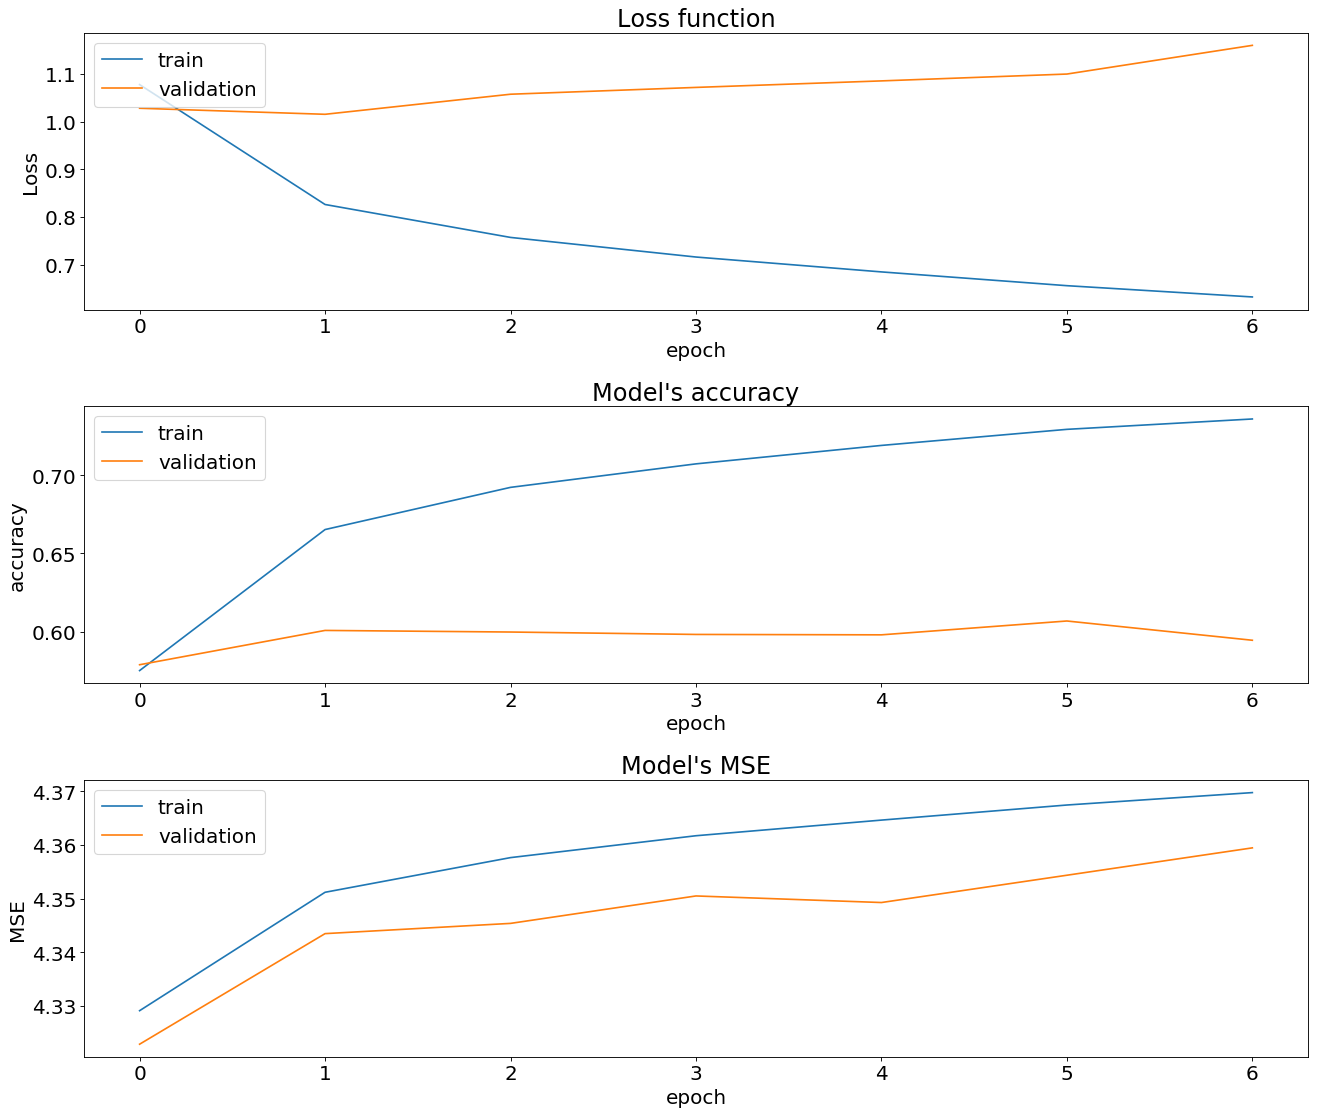

In [5]:
plots_from_history('model6_LSTM_conv1d_no_class_weights30_epochs_history.p')

Okazuje się, że sposród opisanych powyżej modeli ten konkretny osiągnął najlepszy wynik *accuracy* na zestawie testowym - znajduje się 11 pp. ponad benchmarkiem:

In [7]:
! cat ./script_models/test_set_accuracy_outputs/model6_LSTM_conv1d_no_class_weights30_epochs.txt

[1.0090085470370758, 0.6073077, 4.125505]


Kolejne przemyślenie dotyczy czegoś, co w badaniu brałem za pewnik. Mianowicie, funkcja straty w każdej z prezentowych architektur to zalecana (i często używana domyślnie) *categorical cross entropy*. Postanowiłem zostosować inne funkcje straty.

### Dywergencja Kullbacka-Leiblera

Przy wykorzystaniu early stopping model przestał trenować się na 7. epoce. Biorąc pod uwagę poniższe wykresy (brak konwergencji obu wykresów funkcji straty) funkcja nie nadaje się do zadania.

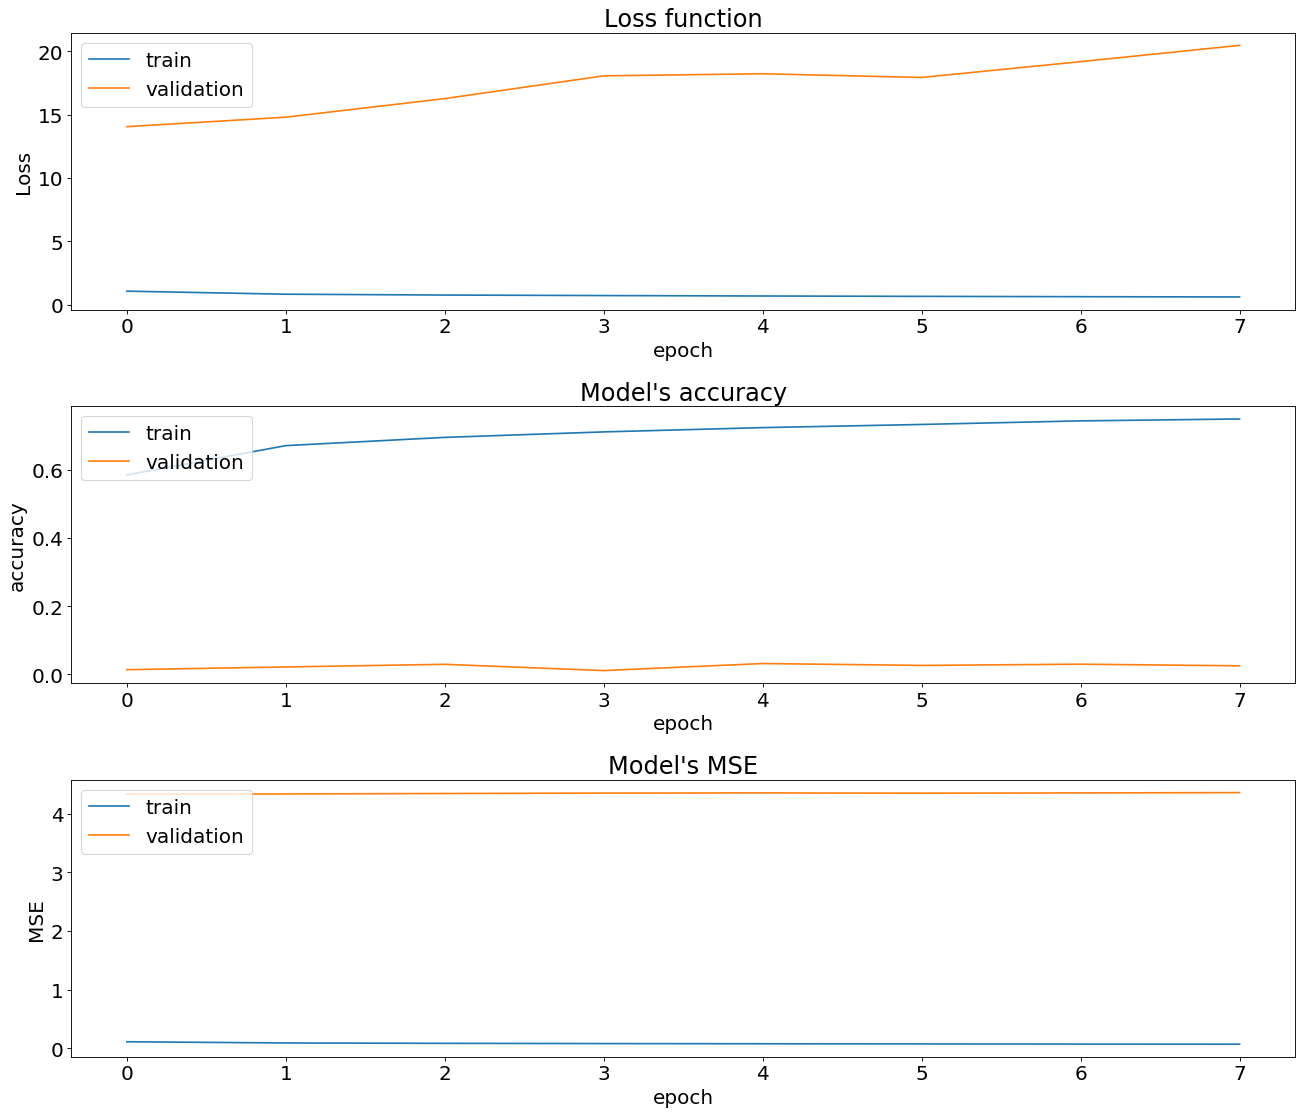

In [9]:
plots_from_history('model6_LSTM_conv1d_no_class_weights_kulback30_epochs_history.p')

### Cosine proximity

Użycie funkcji straty opierającej się na podobieństwie dwóch wektorów liczonego za pomocą cosinusa pomiędzy nimi pozwoliło uzyskać 100% dokładność na danych testowych. Model oparty o **LSTM** i **warstwy konwolucyjne** okazał się być najlepszy, gdy chodzi o jakość mierzoną *accuracy* dla zestawu testowego, podczas gdy mierząc jakość modelu błędem średniokwadratowym (MSE) okazał się być najgorszy.

Kod w pliku: `model6_LSTM_conv1d_no_class_weights_cosine_prox.py`.

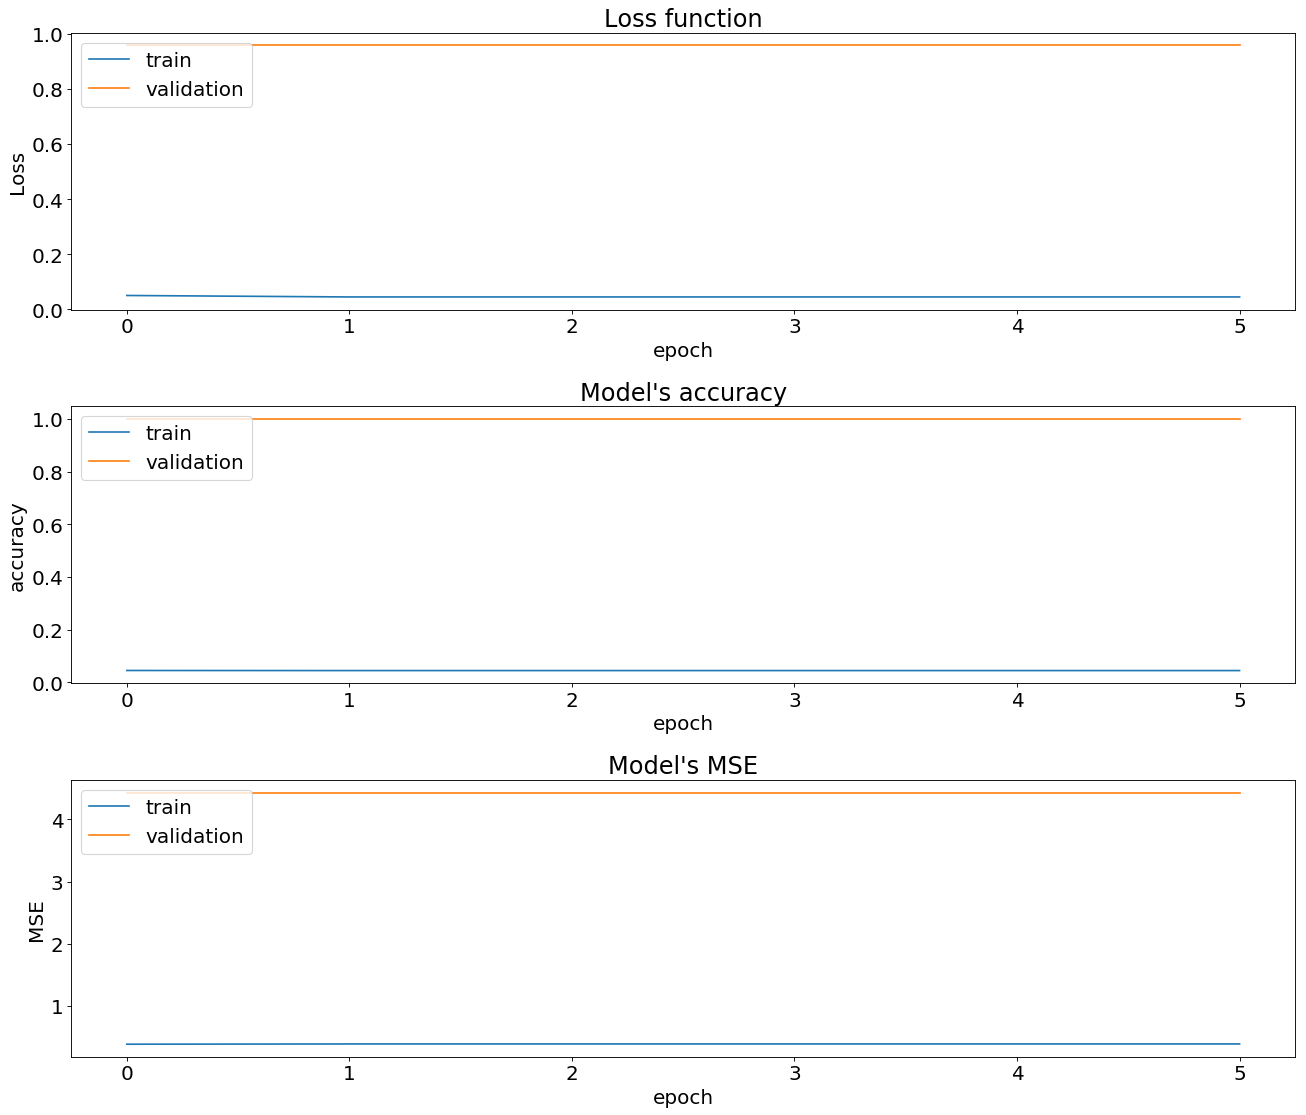

In [11]:
plots_from_history('model6_LSTM_conv1d_no_class_weights_cosine_prox30_epochs_history.p')

In [12]:
! cat ./script_models/test_set_accuracy_outputs/model6_LSTM_conv1d_no_class_weights_cosine_prox30_epochs.txt

[0.946538342145773, 1.0, 4.214693]
